In [1]:
import pystan
%pylab inline
np.set_printoptions(suppress=True)
from scipy import stats
from scipy.stats import scoreatpercentile as sap
from scipy.stats import gaussian_kde
from scipy.special import ncfdtr,ncfdtri,gamma,digamma,polygamma
import warnings
warnings.filterwarnings("ignore")

def reformatData(dat,rank=False):   
    out=[]
    for h in range(dat.shape[0]):
        out.append([])
        if rank:
            v1=dat[h,:,:].sum(1)
            v2=np.zeros(v1.size+1)
            v2[1:]=v1.cumsum()
            for i in range(v1.size):
                v1[i]=(v2[i]+v2[i+1]+1)/2.
        else: v1=range(dat.shape[1])
        for g in range(dat.shape[2]):
            for k in range(dat.shape[1]):
                out[-1].extend([v1[k]]*int(dat[h,k,g]))  
    return np.array(out).T


def plotEstim(x,y,clr='b',alpha=0.05):
    plt.grid(True)
    plt.plot(x,np.median(y,axis=1),clr)
    xx=np.concatenate([x,x[::-1]])
    lb=sap(y,alpha*100/2,axis=1)
    ub=sap(y,100-alpha*100/2,axis=1)
    ci=np.concatenate([lb,ub[::-1]])
    plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
            alpha=0.2,fill=True,fc=clr,ec=clr))
    #plt.ylim([np.min(ci),np.max(ci)])

Populating the interactive namespace from numpy and matplotlib


# ANOVA Power simulation: Main Effects vs. Interaction

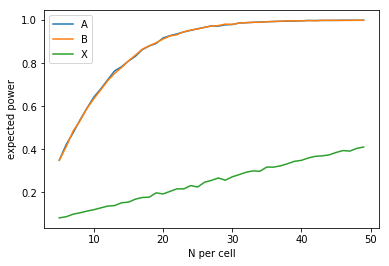

In [511]:

Ns=np.arange(20,200,4); 
K=10000;
ps=np.zeros((Ns.size,3))
res=np.zeros(4)
cs=np.zeros((Ns.size,8))
i=0
for N in Ns:
    for k in range(K):
        x1=np.zeros(N);x1[int(N/2):]=1
        x2=np.mod(range(N),2)
        y= 42+x1+x2+x1*x2+np.random.randn(N)*2
        tot=np.square(y-y.mean()).sum()
        
        x=np.ones((N,4))
        x[:,1]=x1*x2
        x[:,2]=x1*(1-x2)
        x[:,3]=(1-x1)*x2
        res[0]=np.linalg.lstsq(x,y)[1]
        
        x=np.ones((N,2))
        x[:,1]=x1
        res[1]=tot-np.linalg.lstsq(x,y)[1]
        
        x[:,1]=x2
        res[2]=tot-np.linalg.lstsq(x,y)[1]
        
        res[3]=tot-res[0]-res[1]-res[2]
        
        mss=res/np.float32(np.array([N-4,1,1,1]))
        F=mss[1:]/mss[0]
        p=1-stats.f.cdf(F,1,N-4)
        p=p<0.05
        ps[i,:]+=np.int32(p)
        cs[i,p[0]*4+p[1]*2+p[2]]+=1
    i+=1
ps/=float(K)
cs/=float(K)
for k in range(ps.shape[1]): plt.plot(Ns/4, ps[:,k])
plt.legend(['A','B','X'],loc=2)
plt.xlabel('N per cell')
plt.ylabel('expected power');

# Comparison Exact Power vs Simulation

Populating the interactive namespace from numpy and matplotlib
0.163299316186 0.0744205722345
0.163299316186 0.0809635961004
0.163299316186 0.087586487037
0.163299316186 0.0942907033298
0.163299316186 0.101070011887
0.163299316186 0.107930240348
0.163299316186 0.114865146059
0.163299316186 0.121871443884
0.163299316186 0.128945639369
0.163299316186 0.1360841273
0.163299316186 0.143283252337
0.163299316186 0.150539347718
0.163299316186 0.157848760756
0.163299316186 0.165202839518
0.163299316186 0.172606567618
0.163299316186 0.180052562007
0.163299316186 0.187537308726
0.163299316186 0.19505735337
0.163299316186 0.202609304458
0.163299316186 0.210189835951
0.163299316186 0.217795689131
0.163299316186 0.225423673981
0.163299316186 0.2330706702
0.163299316186 0.240733627912
0.163299316186 0.248409568128
0.163299316186 0.256095583025
0.163299316186 0.263788836048
0.163299316186 0.271481190389
0.163299316186 0.27917973568
0.163299316186 0.286877308057
0.163299316186 0.294571343506
0.16329931

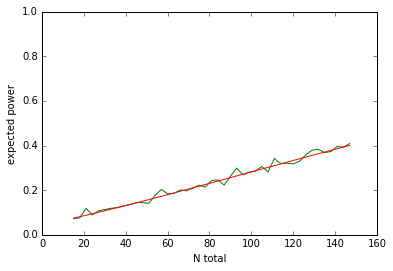

In [6]:
%pylab inline
from scipy import stats
from scipy.special import ncfdtr
Ns=np.arange(15,150,3); 
K=1000;
sigma=5.
alpha=0.05
res=np.zeros(2)
means=np.float32([42,43,44])
kk=means.size
ps=np.zeros((Ns.size,3))
np.random.seed(3)

ii=0
for N in Ns:
    x=np.zeros(N);
    for i in range(kk):  x[i*N/kk:(i+1)*N/kk]=means[i]
    temp=np.square(means-means.mean()).sum()
    es=np.sqrt(temp/float(sigma**2)/float(kk))
    fcrit=stats.f.ppf(1-alpha,2,N-kk)
    #ncfdtri(2,12,1**2*15,ncfdtr(2,12,1**2*15,5))
    ps[ii,2]=1-ncfdtr(2,N-kk,es**2*N,fcrit)
    print es,ps[ii,2]
    for k in range(K):
        y= x+np.random.randn(N)*sigma
        tot=np.square(y-y.mean()).sum()

        xin=np.zeros((N,kk))
        #xin[:,0]=1
        for i in range(0,kk):
            xin[i*N/kk:(i+1)*N/kk,i]=1
        
        res[1]=np.linalg.lstsq(xin,y)[1]
        #xin=np.ones((N,1))
        res[0]=tot-res[1]
        
        mss=res/np.float32(np.array([2,N-kk]))
        F=mss[0]/mss[1]
        ps[ii,0]+=np.int32(fcrit<F)
        
        ssb=(N/kk)*((y[x==0].mean()-y.mean())**2+(y[x==1].mean()-y.mean())**2+
             (y[x==2].mean()-y.mean())**2)
        ssw=(np.square(y[x==0]-y[x==0].mean()).sum()+
                   np.square(y[x==1]-y[x==1].mean()).sum()+
                   np.square(y[x==2]-y[x==2].mean()).sum())
        F=(N-3)*ssb/2./ssw

        ps[ii,1]+=np.int32(fcrit<F)
    ii+=1
ps[:,0]/=float(K)
ps[:,1]/=float(K)
plt.plot(Ns, ps[:,0],'g')
plt.plot(Ns, ps[:,2],'r')
plt.ylim([0,1])
plt.xlabel('N total')
plt.ylabel('expected power');

# Comparison Power Anova vs Kruskal-Wallis vs Likelihood Ratio

In [170]:
%pylab inline
from scipy import stats
from scipy.special import ncfdtr
from scipy.stats import scoreatpercentile as sap
Ns=np.arange(15,150,3); 
K=1000;
sigma=1.
alpha=0.05
res=np.zeros(2)
offset=40
D=10
ps=np.zeros((Ns.size,D,8))
np.random.seed(3)
clr=['r','g','b']
ii=0
for N in Ns:
    
    for d in range(D):
        means=np.float32([offset-d*0.3,offset,offset+d*0.1])
        kk=means.size
        x=np.zeros(N);
        for i in range(kk):  x[i*N/kk:(i+1)*N/kk]=means[i]
        temp=np.square(means-means.mean()).sum()
        es=np.sqrt(temp/float(sigma**2)/float(kk))
        fcrit=stats.f.ppf(1-alpha,2,N-kk)
        ps[ii,d,0]=1-ncfdtr(2,N-kk,es**2*N,fcrit)
        lr=np.zeros(K)*np.nan
        chicrit=stats.chi2.ppf(1-alpha,kk-1)
        
        for k in range(K):
            y= x+np.random.randn(N)*sigma
            tot=np.square(y-y.mean()).sum()
            xin=np.zeros((N,kk))
            for i in range(0,kk):
                xin[i*N/kk:(i+1)*N/kk,i]=1
            res[1]=np.linalg.lstsq(xin,y)[1]
            res[0]=tot-res[1]
            #anova ftest
            mss=res/np.float32(np.array([2,N-kk]))
            ps[ii,d,1]+=np.int32(fcrit<mss[0]/mss[1])
            #likelihood ratio
            s=np.var(y)
            loglik=-N*np.log(s)-np.array([res[1],tot])/s**2/2.
            lr[k]=np.exp(loglik[1]-loglik[0])
            #kruskal wallis
            r=np.atleast_2d(np.argsort(y))+1
            temp=np.copy(xin)
            temp[temp==0]=np.nan
            nom=(N-1)*(N/kk)*np.square(np.nanmean(r.T*temp,axis=0)-r.mean()).sum()
            denom=np.square(r-r.mean()).sum()
            ps[ii,d,3]+= np.int32(chicrit< nom/denom)
        if not d: c=sap(lr,100*alpha)
        ps[ii,d,2]=np.int32(c>lr).mean()
    ii+=1
for g in [1,3]: ps[:,:,g]/=float(K)


Populating the interactive namespace from numpy and matplotlib


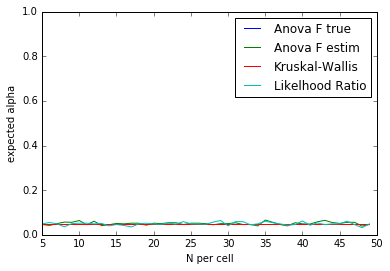

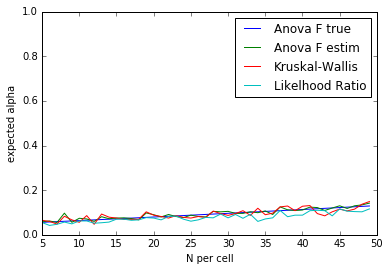

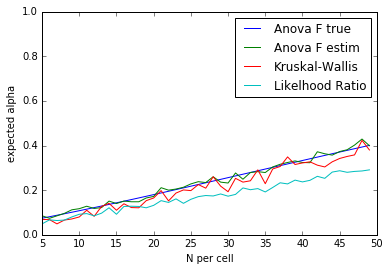

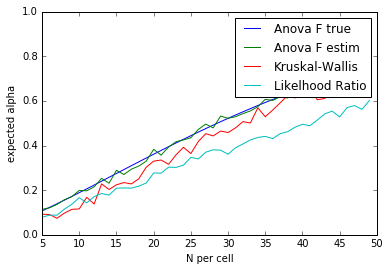

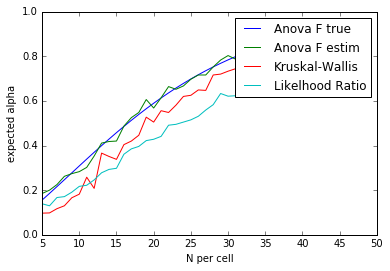

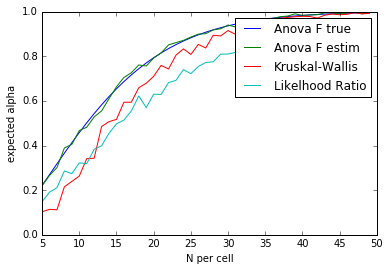

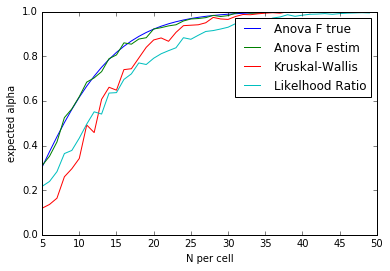

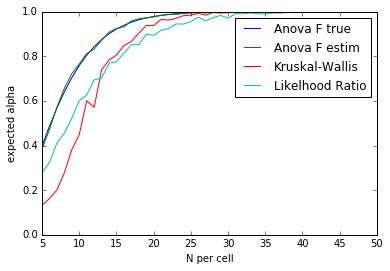

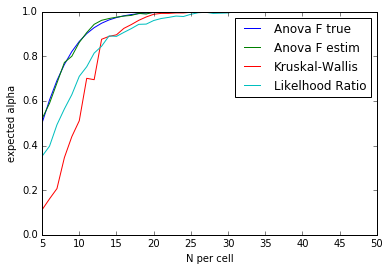

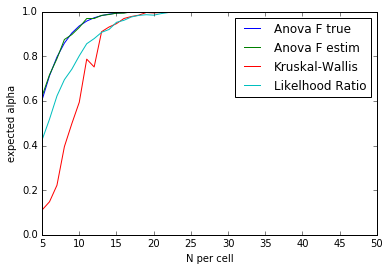

In [169]:
for d in range(D):
    plt.figure()
    plt.plot(Ns/kk,ps[:,d,:4])
    plt.legend(['Anova F true','Anova F estim','Kruskal-Wallis','Likelhood Ratio'])
    plt.ylim([0,1])
    plt.ylabel('expected alpha');
    plt.xlabel('N per cell')

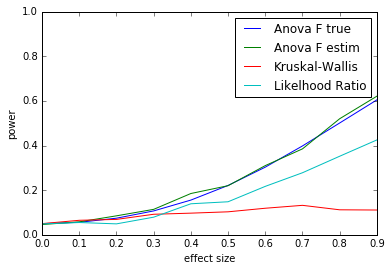

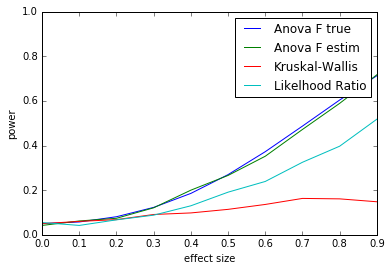

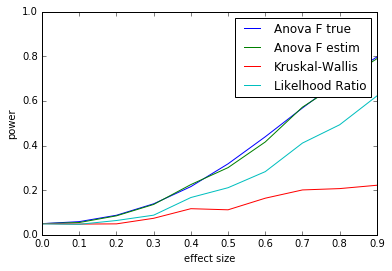

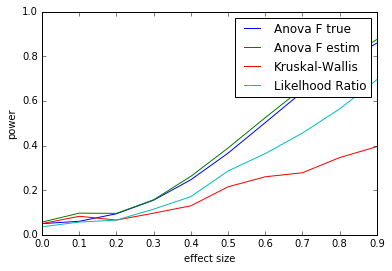

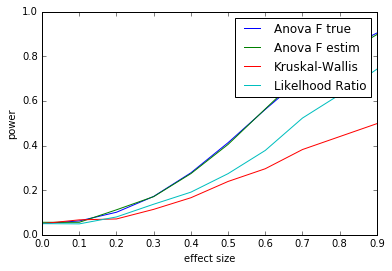

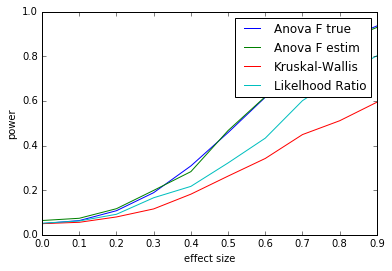

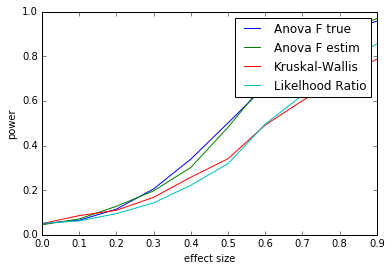

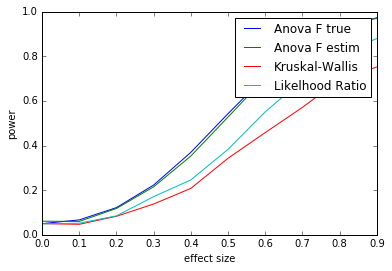

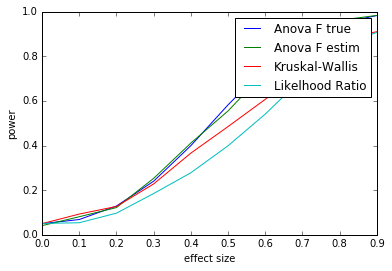

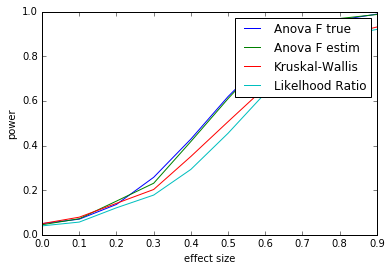

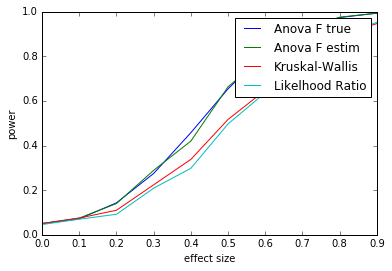

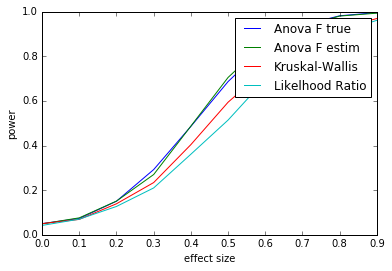

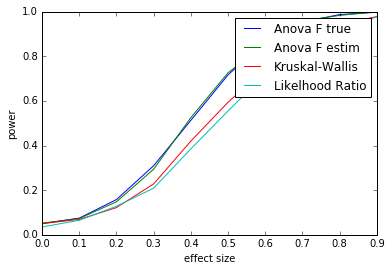

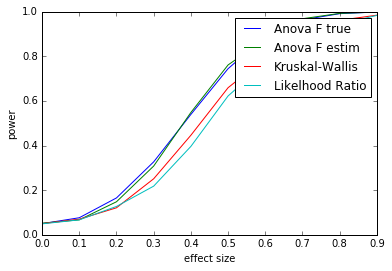

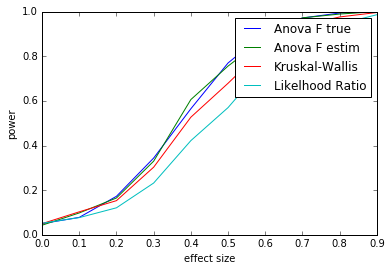

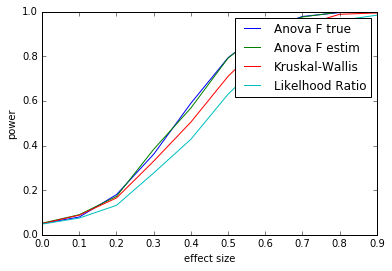

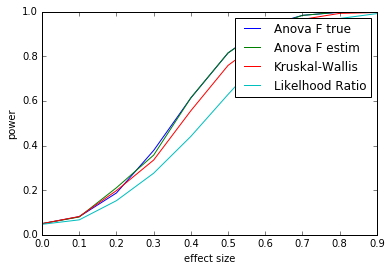

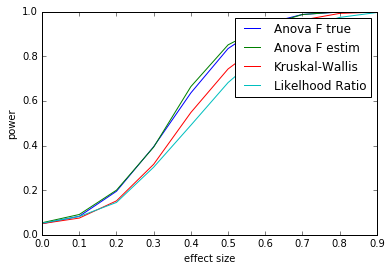

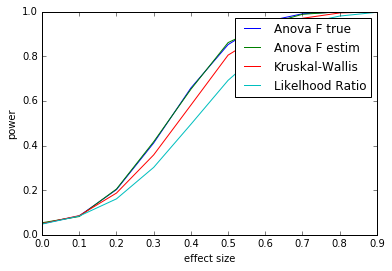

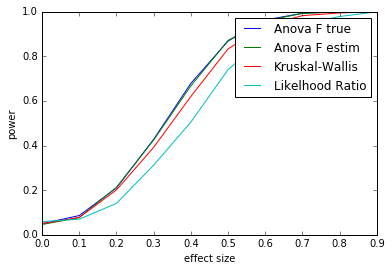

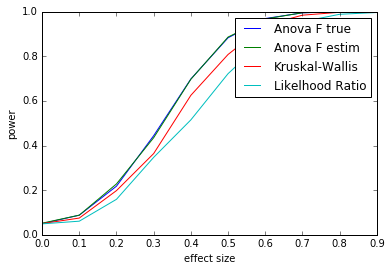

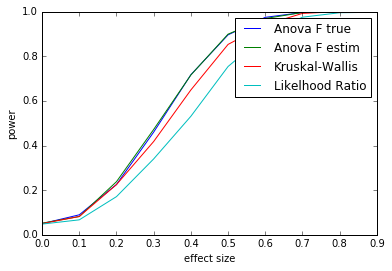

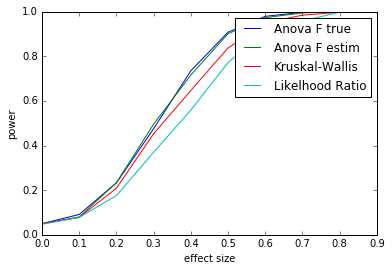

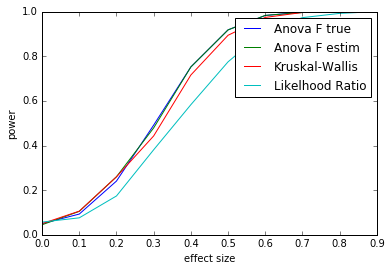

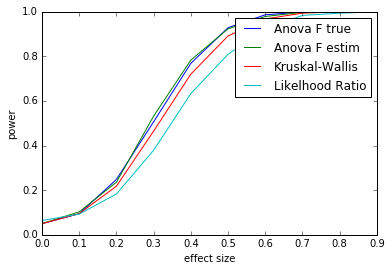

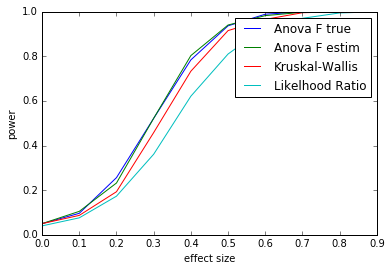

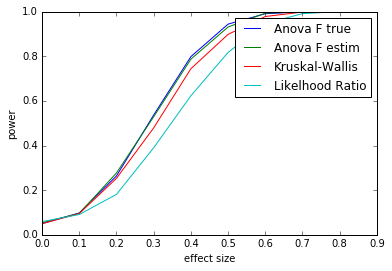

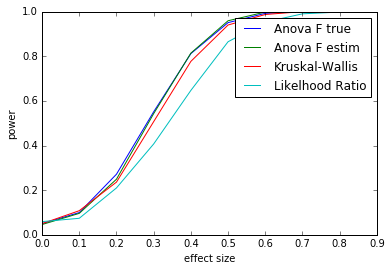

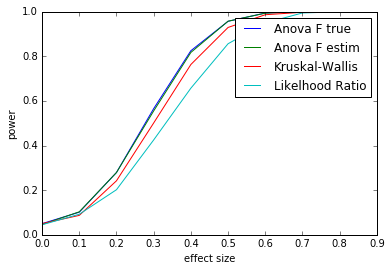

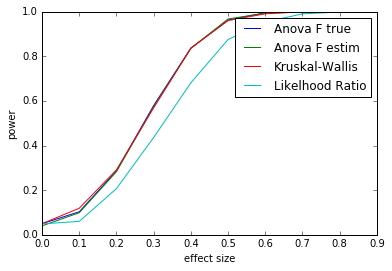

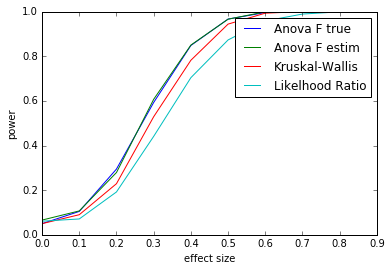

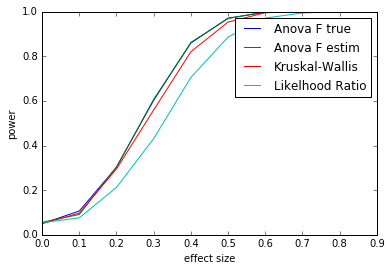

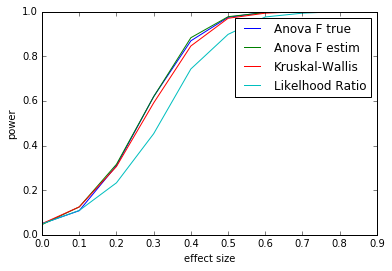

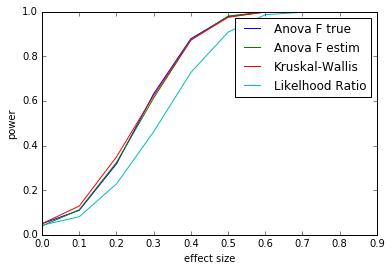

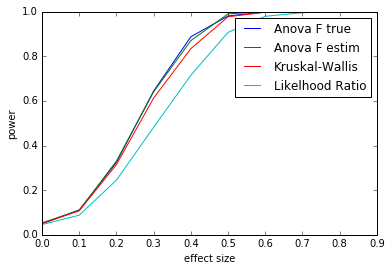

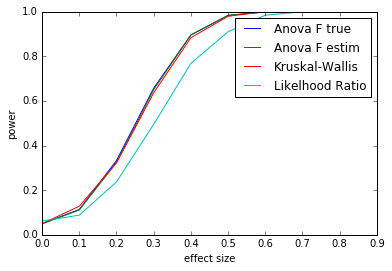

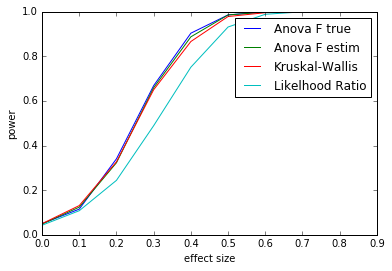

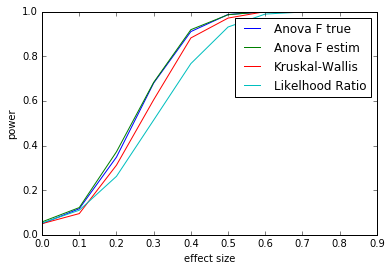

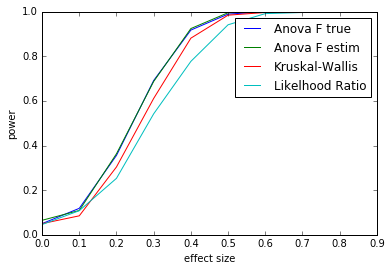

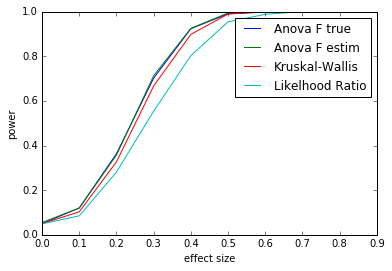

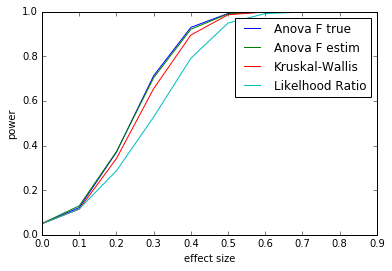

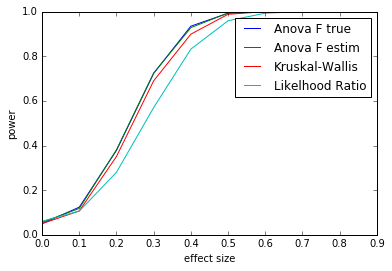

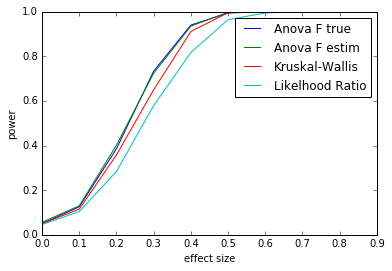

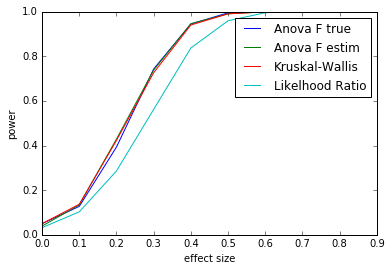

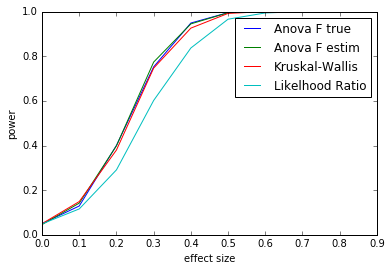

In [167]:
for n in range(Ns.size):
    plt.figure()
    plt.plot(np.arange(D)*0.3,ps[n,:,:4])
    plt.legend(['Anova F true','Anova F estim','Kruskal-Wallis','Likelhood Ratio'])
    plt.ylim([0,1])
    plt.ylabel('power');
    plt.xlabel('effect size')

# Anova, KW with ordered data from 3 groups

In [132]:
def anova3groups(y,alpha=0.05):
    '''
    nreps=1000
    alpha=0.05
    temp=np.zeros((nreps,5,3))
    for g in range(3):
        #print(es,offset,g)
        temp[:,:,g]=orderedLogitRvs(0+(g-1)*1,np.array([-3,-1,1,3]),50,size=nreps)
    y=reformatData(temp)
    out=anova3groups(y,alpha)
    '''
    N=int(y.shape[0]/3)
    fcrit=stats.f.ppf(1-alpha,2,3*N-3)
    #fcrit1=ncfdtri(2,3*N-3,esH1**2*3*N,alpha)
    x=np.zeros((N*3,3))
    for i in range(0,3):
            x[i*N:(i+1)*N,i]=1
    ss=np.zeros((2,y.shape[1]))
    ss[1,:]=np.linalg.lstsq(x,y)[1]
    tot=np.square(y-np.atleast_2d(y.mean(0))).sum(0)
    ss[0,:]=tot-ss[1,:]
    mss=ss/np.float32(np.array([2,3*N-3],ndmin=2).T)
    #print(fcrit,mss[0,0],mss[1,0])
    p=1-stats.f.cdf(mss[0,:]/mss[1,:],2,3*N-3)
    return np.nanmean(np.int32(fcrit<mss[0,:]/mss[1,:])),np.median(p)

def kruskalWallis(y,alpha=0.05):
    from scipy.stats import chi2
    N=int(y.shape[0]/3)
    chicrit=chi2.ppf(1-alpha,2)
    x=np.zeros((N*3,3))*np.nan
    for i in range(0,3):
            x[i*N:(i+1)*N,i]=1
    y=np.array(y,ndmin=3).T
    x=np.array(x,ndmin=3)
    #print(y[0,:,:],x[0,:,:])
    nom=(N*3-1)*N*np.square(np.nanmean(y*x,axis=1)-y.mean(1)).sum(1)
    denom=np.square(np.squeeze(y)-y.mean(1)).sum(1)
    #print(nom[0], denom[0],nom[0]/denom[0])
    h=nom/denom
    #h[np.logical_and(nom==0,denom==0)]=0
    return np.nanmean(np.int32(chicrit< h))

def plotStuff(ess,Ns,offsets,D):
    plt.figure(figsize=(12,12))
    for i in range(len(Ns)):
        for j in range(len(ess)):
            ax=plt.subplot(len(Ns),len(ess),i*len(ess)+j+1)
            plt.plot(offsets,D[j,i,:,0],'r')
            plt.plot(offsets,D[j,i,:,1],'g')
            plt.ylim([-0.1,1])
            if i ==(len(Ns)-1): plt.xlabel('Es= %.1f'%ess[j])
            else: ax.set_xticklabels([])
            if j ==0: plt.ylabel('N= %d'%Ns[i])
            else: ax.set_yticklabels([])

0 0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r =

0 1
0 2
0 3
1 0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


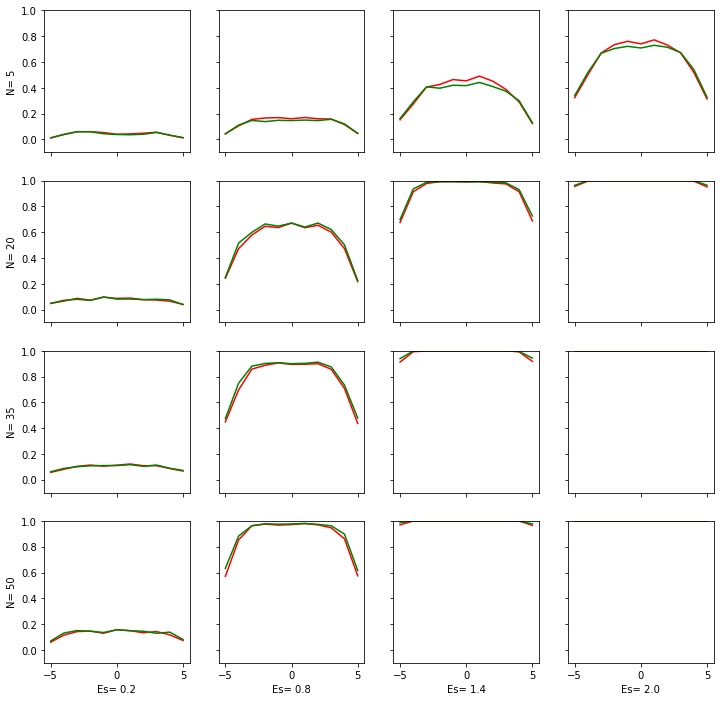

In [121]:
alpha=0.05
noffsets=11
nreps=1000
offsets=np.linspace(-5,5,noffsets)
Ns=np.int32(np.linspace(5,50,4))
ess=np.linspace(0.2,2,4)
D=np.zeros((len(ess),len(Ns),len(offsets),2))
for ie in range(ess.size):
    for iN in range(Ns.size):
        print(ie,iN)
        for io in range(len(offsets)):
            temp=np.zeros((np.abs(nreps),5,3))
            for g in range(3):
                #print(es,offset,g)
                temp[:,:,g]=orderedLogitRvs(offsets[io]+(g-1)*ess[ie],
                                np.array([-3,-1,1,3]),Ns[iN],size=nreps)
            y=reformatData(temp)
            D[ie,iN,io,0]=anova3groups(y,alpha)[0]
            #lr=LRorderedLogit(y)
            #out[2]=np.nanmean(lr>cLR)
            #out[5]=np.nanmean(lr<cLR0)    
            y=reformatData(temp,rank=True)
            D[ie,iN,io,1]=kruskalWallis(y,alpha)
plotStuff(ess,Ns,offsets,D)

# Anova, KW: 2x2 interaction

In [102]:
def anova2Bx2B(x1,x2,y,alpha=0.05):
    '''
    nreps=1000
    alpha=0.05
    temp=np.zeros((nreps,5,3))
    for g in range(3):
        #print(es,offset,g)
        temp[:,:,g]=orderedLogitRvs(0+(g-1)*1,np.array([-3,-1,1,3]),50,size=nreps)
    y=reformatData(temp)
    out=anova3groups(y,alpha)
    '''
    res=np.zeros((y.shape[1],4))
    N=int(y.shape[0]/4)
    tot=np.square(y-np.atleast_2d(y.mean(0))).sum(0)
    #CM=y.sum(0)**2/y.shape[0]
    #SStot=np.square(y).sum(0)-CM
    x=np.ones((4*N,4))
    x[:,1]=x1*x2
    x[:,2]=x1*(1-x2)
    x[:,3]=(1-x1)*x2
    #u1=np.square(y[x[:,1]>0,:].sum(0))
    #u2=np.square(y[x[:,2]>0,:].sum(0))
    #u3=np.square(y[x[:,3]>0,:].sum(0))
    #u4=np.square(y[(1-x1)*(1-x2)>0,:].sum(0))
    res[:,0]=np.linalg.lstsq(x,y)[1]
    x=np.ones((4*N,2))
    x[:,1]=x1
    res[:,1]=tot-np.linalg.lstsq(x,y)[1]
    #SS1=2*(np.square(y[x1==1,:].sum(0))+np.square(y[x1==0,:].sum(0)))/y.shape[0]-CM
    x[:,1]=x2
    res[:,2]=tot-np.linalg.lstsq(x,y)[1]
    #SS2=2*(np.square(y[x2==1,:].sum(0))+np.square(y[x2==0,:].sum(0)))/y.shape[0]-CM
    #print(res[:,2]-SS2)
    #SS12=4*(u1+u2+u3+u4)/y.shape[0]-CM-SS1-SS2
    res[:,3]=tot-res[:,0]-res[:,1]-res[:,2]
    #print(res[:,3]-SS12)
    mss=res/np.float32(np.array([4*N-4,1,1,1]))
    F=mss[:,1:]/np.atleast_2d(mss[:,0]).T
    p=1-stats.f.cdf(F,1,4*N-4)
    return np.nanmean(np.int32(p<alpha),0) 
    
        
R=100
N=32       
x1=np.zeros(N);x1[int(N/2):]=1
x2=np.mod(range(N),2)
y= 42+x1+x2+x1*x2+np.random.randn(R,N)*2
anova2Bx2B(x1,x2,y.T)

array([ 0.57,  0.53,  0.09])

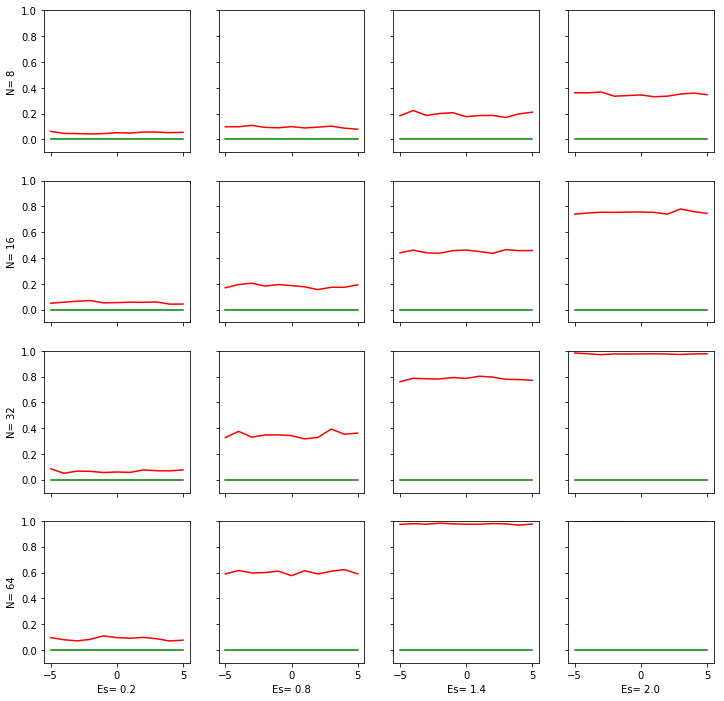

In [122]:
alpha=0.05
noffsets=11
nreps=1000
offsets=np.linspace(-5,5,noffsets)
Ns=np.array([8,16,32,64])
ess=np.linspace(0.2,2,4)
D=np.zeros((len(ess),len(Ns),len(offsets),2))
for ie in range(ess.size):
    for iN in range(Ns.size):
        #print(ie,iN)
        for io in range(len(offsets)):
            x1=np.zeros(Ns[iN]);x1[int(Ns[iN]/2):]=1
            x2=np.mod(range(Ns[iN]),2)
            y= offsets[io]+x1+x2+ess[ie]*x1*x2+np.random.randn(nreps,Ns[iN])*0.7
            D[ie,iN,io,0]=anova2Bx2B(x1,x2,y.T)[2]
plotStuff(ess,Ns,offsets,D)

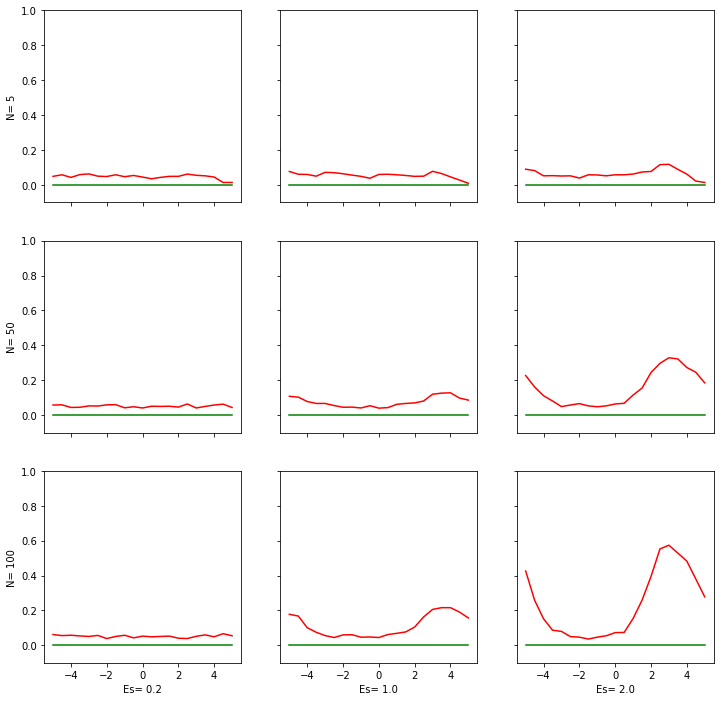

In [142]:
alpha=0.05
noffsets=21
nreps=1000
offsets=np.linspace(-5,5,noffsets)
Ns=np.array([5,50,100])
ess=np.array([0.2,1,2])
D=np.zeros((len(ess),len(Ns),len(offsets),2))
for ie in range(ess.size):
    for iN in range(Ns.size):
        #print(ie,iN)
        for io in range(len(offsets)):
            temp=np.zeros((np.abs(nreps),5,4))
            x1=np.zeros(Ns[iN]*4)
            x2=np.zeros(Ns[iN]*4)
            for g1 in range(2):
                for g2 in range(2):
                    temp[:,:,g1*2+g2]=orderedLogitRvs(offsets[io]+g1+g2*ess[ie],
                                np.array([-3,-1,1,3]),Ns[iN],size=nreps)
            x1[int(x1.shape[0]/2):]=1
            t=int(x2.shape[0]/4)
            x2[t:2*t]=1;x2[3*t:]=1
            y=reformatData(temp)
            D[ie,iN,io,0]=anova2Bx2B(x1,x2,y,alpha=alpha)[2]
plotStuff(ess,Ns,offsets,D)

# STAN: 2x2 Interaction

In [171]:
import pystan
model = """
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1,upper=K> y[N];
    real x1[N];
    real x2[N];
}parameters {
    real<lower=-20,upper=20> m[3] ;
    ordered[K-1] c;
}model {
    for (k in 1:(K-1)){
        c[k]~ uniform(-100,100);
    }
    for (n in 1:N){
        y[n]~ordered_logistic(x1[n]*m[1]+x2[n]*m[2]+x1[n]*x2[n]*m[3],c);  
    }
}
"""
sm2x2 = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_94258e36263d7b24ee2d840318b670a1 NOW.


In [178]:
nreps=-1
noffsets=11
offsets=np.linspace(-5,5,noffsets)
D=np.zeros((len(ess),len(Ns),len(offsets),np.abs(nreps),4500,3))
ie=2;iN=2;ir=0
for ie in range(ess.size):
    for iN in range(Ns.size):
        print(ie,iN)
        for io in range(len(offsets)):
            temp=np.zeros((np.abs(nreps),5,4))
            x1=np.zeros(Ns[iN]*4)
            x2=np.zeros(Ns[iN]*4)
            for g1 in range(2):
                for g2 in range(2):
                    temp[:,:,g1*2+g2]=orderedLogitRvs(offsets[io]+g1+g2*ess[ie],
                                np.array([-3,-1,1,3]),Ns[iN],size=nreps)
            x1[int(x1.shape[0]/2):]=1
            t=int(x2.shape[0]/4)
            x2[t:2*t]=1;x2[3*t:]=1
            y=reformatData(temp)
            dat = {'N': np.int32(y.shape[0]),'K':5,'y':np.int32(y[:,0]+1),'x1':x1,'x2':x2}
            seed=np.random.randint(2**16)
            fit=sm2x2.sampling(data=dat,iter=5000,chains=6,thin=4,warmup=2000,n_jobs=6,seed=seed)
            w=fit.extract()
            print(fit)
            D[ie,iN,io,ir,:]=w['m']
            #D[ie,iN,io,ir,0]=np.median(p)
            #D[ie,iN,io,ir,1]=sap(p,97.5)
            #D[ie,iN,io,ir,2]=sap(p,2.5)

0 0
Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]  -0.01    0.15    2.0  -4.12  -1.29  -0.01   1.27   3.96    175   1.02
m[1]  -0.08    0.16    2.0  -4.02  -1.35  -0.07   1.15    4.1    162   1.02
m[2]   0.08    0.22   2.87  -5.42   -1.8   0.04    1.9   6.02    165   1.02
c[0]   1.82    0.11   1.39  -0.46   0.83   1.67   2.62   5.02    173   1.02
c[1]  28.31    0.95  18.82   4.09  13.32  24.39  39.58  73.62    392   1.01
c[2]  52.53    0.97  21.52  13.59  35.96  52.53  69.35   91.3    491    1.0
c[3]  76.71    0.54  18.25  33.49  65.07  80.92  91.88  99.26   1143   1.01
lp__   2.99    0.09   2.17  -2.09   1.75    3.3   4.61   6.18    539   1.01

Samples were drawn using NUTS at Tue Nov 21 09:42:04 2017.
For each parameter, n_eff is a crude measure of effective sample

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   2.78    0.04   1.81  -0.28    1.5   2.66   3.87    6.7   2089    1.0
m[1]   1.39    0.03   1.45  -1.35    0.4   1.39   2.33   4.36   2320    1.0
m[2]   -1.5    0.06   2.53  -6.43  -3.13  -1.46    0.2   3.33   2033    1.0
c[0] -67.76    0.53   22.9 -98.71 -87.17 -71.78 -51.46 -18.51   1857    1.0
c[1] -35.94    0.54  22.67 -85.03 -51.61 -32.26 -16.96  -4.92   1788   1.01
c[2]  -2.51    0.02   1.43  -5.65  -3.37  -2.38  -1.51  -0.08   3487    1.0
c[3]    0.8    0.02   1.07  -1.18    0.1   0.77   1.49   2.94   2617    1.0
lp__  -2.98    0.04   2.15  -8.18  -4.17  -2.63  -1.38   0.13   2492    1.0

Samples were drawn using NUTS at Tue Nov 21 09:46:38 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   0.94  5.8e-3   0.37   0.22   0.69   0.94   1.19    1.7   4217    1.0
m[1]   0.19  5.7e-3   0.37  -0.52  -0.06   0.19   0.44   0.92   4201    1.0
m[2]  -0.02  8.0e-3   0.52  -1.05  -0.37  -0.02   0.33   0.98   4280    1.0
c[0]  -3.14  7.4e-3   0.47  -4.09  -3.43  -3.11  -2.82  -2.29   4016    1.0
c[1]  -1.08  4.3e-3   0.29  -1.64  -1.28  -1.09  -0.89  -0.53   4330    1.0
c[2]   0.96  4.2e-3   0.28   0.42   0.77   0.95   1.14   1.52   4427    1.0
c[3]   2.95  5.3e-3   0.35   2.26   2.72   2.94   3.18   3.67   4484    1.0
lp__ -255.7    0.03   1.87 -260.2 -256.7 -255.4 -254.4 -253.0   4228    1.0

Samples were drawn using NUTS at Tue Nov 21 09:50:22 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   1.01  4.1e-3   0.27   0.48   0.82   1.01    1.2   1.55   4389    1.0
m[1]    0.2  4.2e-3   0.27  -0.35   0.02    0.2   0.38   0.72   4223    1.0
m[2] 7.3e-3  5.8e-3   0.37  -0.72  -0.24 3.2e-3   0.25   0.76   4217    1.0
c[0]-2.6e-3  2.9e-3    0.2  -0.39  -0.13-4.6e-3   0.13   0.38   4452    1.0
c[1]   2.02  3.3e-3   0.22   1.58   1.86   2.01   2.16   2.48   4500    1.0
c[2]   4.01  4.9e-3   0.33   3.39   3.79   3.99   4.23   4.66   4500    1.0
c[3]   6.37    0.01   0.83   5.01    5.8   6.28   6.86   8.28   4500    1.0
lp__ -448.8    0.03   1.87 -453.2 -449.8 -448.4 -447.4 -446.1   4336    1.0

Samples were drawn using NUTS at Tue Nov 21 10:56:42 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   1.02    0.01   0.58  -0.07   0.63    1.0   1.38   2.21   1931    1.0
m[1]   0.24    0.01   0.47  -0.66  -0.07   0.24   0.56   1.15   1614    1.0
m[2]   0.02    0.02   0.88   -1.7  -0.57 3.6e-3    0.6    1.8   1378    1.0
c[0]  -67.6    0.69  22.29 -98.74 -86.43 -71.07 -51.81 -20.34   1030    1.0
c[1] -36.83    0.63  21.88 -85.47 -51.41 -33.01 -18.68  -7.39   1201    1.0
c[2]  -4.03    0.01   0.54  -5.19  -4.37  -3.99  -3.65  -3.05   2242    1.0
c[3]  -2.01  6.1e-3   0.32  -2.67  -2.22   -2.0   -1.8  -1.42   2742    1.0
lp__ -108.3    0.05   2.08 -113.4 -109.5 -108.0 -106.9 -105.4   1901    1.0

Samples were drawn using NUTS at Tue Nov 21 12:39:32 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   0.03    0.03   1.28  -2.51  -0.81   0.04   0.86   2.54   2055    1.0
m[1]-2.2e-3    0.03   1.29  -2.53  -0.87-6.6e-3   0.88    2.5   2056    1.0
m[2]    2.4    0.06   2.13  -1.51   0.94    2.3   3.72   6.85   1230    1.0
c[0] -66.83    0.57  22.75  -98.8 -86.12 -69.94 -50.79 -18.69   1570    1.0
c[1] -35.22    0.56  22.44 -84.52 -50.73 -30.66 -16.59  -4.77   1604    1.0
c[2]  -1.66    0.02   1.01  -3.75   -2.3  -1.61  -0.98   0.23   2480    1.0
c[3]   0.51    0.02   0.93  -1.32  -0.12   0.51   1.12   2.37   2589    1.0
lp__  -7.44    0.04    2.1 -12.46  -8.61  -7.11   -5.9  -4.32   2238    1.0

Samples were drawn using NUTS at Tue Nov 21 12:43:54 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   1.07  5.9e-3   0.38   0.32   0.82   1.07   1.32   1.83   4111    1.0
m[1]   1.08  5.8e-3   0.39   0.34   0.82   1.08   1.35   1.83   4410    1.0
m[2]  -0.15  8.2e-3   0.53  -1.16  -0.51  -0.15   0.21   0.89   4189    1.0
c[0]  -2.09  5.6e-3   0.36  -2.83  -2.33  -2.09  -1.84   -1.4   4239    1.0
c[1] 9.4e-3  4.1e-3   0.27  -0.52  -0.17   0.01   0.19   0.54   4410    1.0
c[2]   2.02  4.7e-3   0.31   1.43   1.81   2.02   2.23   2.66   4500    1.0
c[3]   3.97  6.4e-3   0.42   3.18   3.69   3.96   4.25   4.81   4247    1.0
lp__ -256.5    0.03   1.88 -261.1 -257.5 -256.2 -255.1 -253.9   4283    1.0

Samples were drawn using NUTS at Tue Nov 21 12:55:14 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   1.01  4.7e-3   0.29   0.44   0.81   1.01    1.2   1.59   3922    1.0
m[1]   1.01  4.7e-3    0.3   0.42    0.8   1.01   1.21    1.6   4133    1.0
m[2]-6.1e-3  6.2e-3    0.4  -0.81  -0.27  -0.01   0.26   0.77   4188    1.0
c[0]   1.01  3.5e-3   0.23   0.58   0.86    1.0   1.15   1.47   4207    1.0
c[1]   3.01  4.2e-3   0.27   2.51   2.82    3.0   3.18   3.54   4053    1.0
c[2]   4.97  6.1e-3    0.4   4.21    4.7   4.95   5.23   5.81   4361    1.0
c[3]   7.91    0.02   1.29   5.93   6.99   7.71    8.6  10.96   4395    1.0
lp__ -395.2    0.03   1.87 -399.9 -396.2 -394.9 -393.9 -392.6   4118    1.0

Samples were drawn using NUTS at Tue Nov 21 13:54:03 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   1.02  8.5e-3   0.38   0.26   0.76   1.01   1.26   1.81   2047    1.0
m[1]   1.02  8.1e-3   0.38   0.27   0.77   1.03   1.28    1.8   2219    1.0
m[2]  -0.01    0.02   0.69  -1.33   -0.5  -0.01   0.43   1.39   1480    1.0
c[0] -43.74    5.06  23.75 -93.84 -59.28 -41.79 -24.08  -8.46     22   1.08
c[1]  -5.94    0.03   1.31  -9.07  -6.62  -5.75   -5.0  -3.97   2531    1.0
c[2]  -2.98  6.8e-3   0.36  -3.72  -3.21  -2.97  -2.73  -2.31   2794    1.0
c[3]  -1.01  4.4e-3   0.23  -1.48  -1.15   -1.0  -0.86  -0.57   2769    1.0
lp__ -172.3    0.05   1.96 -176.9 -173.4 -172.0 -170.9 -169.3   1800   1.01

Samples were drawn using NUTS at Tue Nov 21 15:04:17 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   1.24    0.03   1.32  -1.28   0.37   1.21   2.12   3.89   2566    1.0
m[1]   1.23    0.03   1.32  -1.31   0.33   1.19    2.1   3.84   2600    1.0
m[2]   1.16    0.04   2.12  -2.87  -0.22   1.12   2.48   5.45   2486    1.0
c[0] -67.03    0.58  22.76 -98.87 -86.11 -70.74 -50.87  -17.8   1540    1.0
c[1] -35.21     0.5   23.0 -84.62  -51.8  -30.9 -16.06  -3.75   2079    1.0
c[2]  -0.49    0.02   0.93  -2.36  -1.09  -0.51   0.11   1.39   2855    1.0
c[3]   1.72    0.02   1.02  -0.16   1.04   1.68   2.36   3.94   3068    1.0
lp__  -7.39    0.04   2.09 -12.39  -8.58  -7.06  -5.88  -4.25   2372    1.0

Samples were drawn using NUTS at Tue Nov 21 15:29:03 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   1.08  5.9e-3   0.38   0.33   0.82   1.08   1.33   1.83   4228    1.0
m[1]   2.17  6.2e-3    0.4   1.39    1.9   2.17   2.43   2.99   4263    1.0
m[2]  -0.14  8.1e-3   0.52  -1.18   -0.5  -0.14   0.21   0.89   4191    1.0
c[0]  -0.96  4.3e-3   0.29  -1.55  -1.15  -0.96  -0.76   -0.4   4500    1.0
c[1]   1.08  4.4e-3   0.29   0.53   0.89   1.08   1.28   1.67   4367    1.0
c[2]   3.11  5.5e-3   0.36   2.44   2.87    3.1   3.35   3.84   4191    1.0
c[3]   5.14  7.1e-3   0.47   4.25   4.82   5.13   5.46   6.07   4352    1.0
lp__ -249.6    0.03   1.86 -254.0 -250.6 -249.2 -248.2 -246.9   4237    1.0

Samples were drawn using NUTS at Tue Nov 21 15:33:26 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   1.02  6.6e-3   0.38   0.27   0.77   1.02   1.28   1.79   3418    1.0
m[1]   2.03  6.0e-3   0.37   1.33   1.78   2.02   2.27   2.77   3707    1.0
m[2]  -0.02  7.7e-3   0.47  -0.93  -0.34  -0.02   0.29    0.9   3688    1.0
c[0]   2.03  5.2e-3   0.31   1.44   1.81   2.02   2.24   2.68   3583    1.0
c[1]   4.03  5.7e-3   0.35   3.34   3.79   4.02   4.26   4.74   3835    1.0
c[2]   6.04  7.8e-3   0.49   5.14   5.69   6.01   6.35   7.07   3969    1.0
c[3]   8.82    0.02   1.36   6.81   7.87   8.62    9.5  12.18   4500    1.0
lp__ -335.3    0.03   1.89 -339.9 -336.3 -335.0 -333.9 -332.6   3953    1.0

Samples were drawn using NUTS at Tue Nov 21 16:29:12 2017.
For each parameter, n_eff is a crude measure of effective sample siz

Inference for Stan model: anon_model_94258e36263d7b24ee2d840318b670a1.
6 chains, each with iter=5000; warmup=2000; thin=4; 
post-warmup draws per chain=750, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m[0]   0.98    0.02    0.3   0.44   0.76   0.98   1.17   1.58    220   1.03
m[1]   2.02  7.5e-3   0.35   1.35   1.79    2.0   2.25   2.76   2235   1.01
m[2]   0.02    0.01   0.63  -1.13  -0.41   0.03    0.4   1.28   2353   1.01
c[0] -50.07    3.79  26.56 -97.32 -71.33 -48.73 -26.96  -8.24     49   1.08
c[1]  -4.22    0.06   0.67  -5.58  -4.63  -4.16  -3.75  -3.06    132   1.04
c[2]  -1.99  4.8e-3   0.26  -2.53  -2.16  -1.98  -1.81   -1.5   2932    1.0
c[3]  -0.01  5.0e-3   0.19  -0.39  -0.15  -0.02   0.12   0.37   1547   1.01
lp__ -232.2    0.04   1.95 -236.9 -233.3 -231.8 -230.8 -229.4   2444    1.0

Samples were drawn using NUTS at Tue Nov 21 17:10:28 2017.
For each parameter, n_eff is a crude measure of effective sample siz

In [188]:
sap(D[j,i,:,0,:,0],97.5,axis=1)

array([  3.95508118,   5.59402914,   2.55489564,   4.07567571,
         5.26510278,   5.69658611,   3.78803249,   2.55421523,
         6.69405849,   4.1927381 ,  19.52866427])

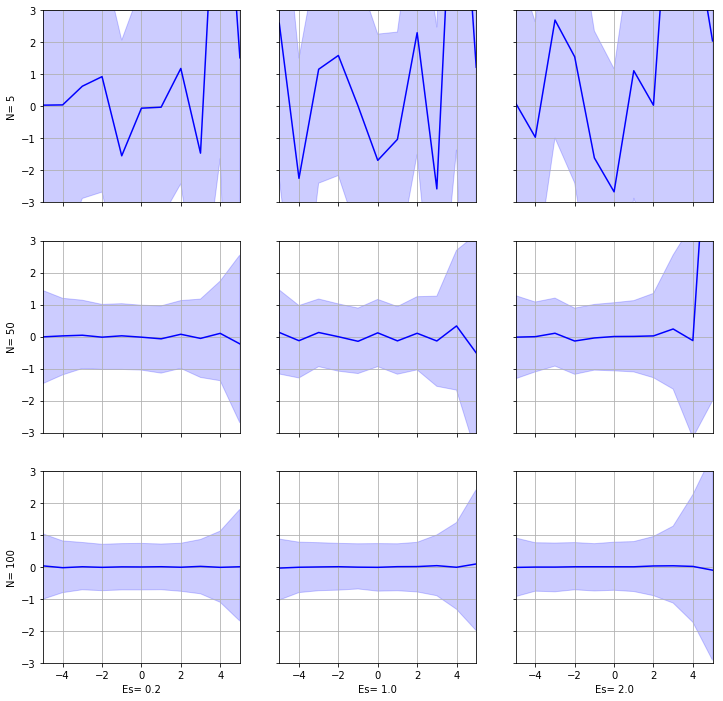

In [196]:
plt.figure(figsize=(12,12))
for i in range(len(Ns)):
    for j in range(len(ess)):
        ax=plt.subplot(len(Ns),len(ess),i*len(ess)+j+1)
        plt.grid(True)
        plt.plot(offsets,np.median(D[j,i,:,0,:,2],axis=1),'b')
        x=np.concatenate([offsets,offsets[::-1]])
        lb=sap(D[j,i,:,0,:,2],2.5,axis=1)
        ub=sap(D[j,i,:,0,:,2],97.5,axis=1)
        ci=np.concatenate([lb,ub[::-1]])
        plt.gca().add_patch(plt.Polygon(np.array([x,ci]).T,
                alpha=0.2,fill=True,fc='b',ec='b'))
        #ax.set_yticks([0,0.25,0.5,0.75,1])
        plt.ylim([-3,3])
        plt.xlim([-5,5])
        if i ==(len(Ns)-1): plt.xlabel('Es= %.1f'%ess[j])
        else: ax.set_xticklabels([])
        if j ==0: plt.ylabel('N= %d'%Ns[i])
        else: ax.set_yticklabels([]) 

In [197]:
np.save('G.npy',D)

 # 1. Continuous floor
 
 ## 1.1 Two Groups
 
 ### 1.1.1 Estimation

In [2]:

qs=np.exp(np.linspace(-.5,.5,3))
bs=np.exp(np.linspace(-.5,.5,3))
ks=np.exp(np.linspace(-1,1.5,21))
ginc=0.25
N=100
R=200
D=np.zeros((ks.size,qs.size,ks.size,R,17))
for i in range(bs.size):
    for j in range(qs.size):
        print(i,j)
        for r in range(R):
            for h in range(ks.size):
                b=bs[i];q=qs[j];dat=[];
                k=np.array([ks[h],invdigamma(digamma(ks[h])+ginc*q)])
                for g in range(2):

                    dat.append(stats.gengamma.rvs(k[g],q,0,b,size=N))
                    dat[-1][dat[-1]==0]=np.exp(-20)
                    D[i,j,h,r,[2*g,2*g+1]]=[np.mean(np.log(dat[-1])),np.var(np.log(dat[-1]),ddof=1)]
                    D[i,j,h,r,[2*g+4,2*g+5]]=[np.mean(dat[-1]),np.var(dat[-1],ddof=1)]
                ts=[]
                for g in range(2):
                    t,p=stats.ttest_ind_from_stats(D[i,j,h,r,2+g*4],
                            np.sqrt(D[i,j,h,r,3+g*4]),N, D[i,j,h,r,g*4],
                            np.sqrt(D[i,j,h,r,1+g*4]),N, equal_var=False)
                    D[i,j,h,r,8+g]=(t>0)*p/2+(1-p/2)*(t<=0)
                    # bayes factor in favor of no difference
                    t,p=stats.ttest_ind_from_stats(D[i,j,h,r,2+g*4],
                            np.sqrt(D[i,j,h,r,3+g*4]),N, D[i,j,h,r,g*4],
                            np.sqrt(D[i,j,h,r,1+g*4]),N, equal_var=True)
                    nn=N/2;v=2*N-2
                    f=lambda g: (2*np.pi*(1+nn*g))**-0.5* ((1+(t**2)/(1+nn*g)/v)**(-(v+1)/2)*g**-1.5*np.exp(-1/2/g))
                    denom=quad(f,0,np.inf)[0]
                    D[i,j,h,r,15+g]=(1+t**2/v)**(-(v+1)/2)/denom
                D[i,j,h,r,10]=stats.mannwhitneyu(dat[0],dat[1],alternative='less')[1]
                #TOST
                #t,p=stats.ttest_ind_from_stats(5.22-0.43,0.95,95, 5.25,0.83,89,equal_var=False)
                k=np.array([3,invdigamma(digamma(3)+ginc*q)])
                ms=b*gamma(k+1/q)/gamma(k)
                for g in range(2):
                    delta=[ginc,ms[1]-ms[0]][g]
                    for gg in range(2):
                        t,p=stats.ttest_ind_from_stats(D[i,j,h,r,g*4+2]+[-1,1][gg]*delta,np.sqrt(D[i,j,h,r,g*4+3]),N,
                            D[i,j,h,r,g*4],np.sqrt(D[i,j,h,r,g*4+1]),N, equal_var=False)
                        D[i,j,h,r,11+gg+g*2]=[(t<=0)*p/2+(1-p/2)*(t>0),(t>0)*p/2+(1-p/2)*(t<=0)][gg]

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


-10.6623698767 3.26911083528e-21
-4.112628381 0.999970363717


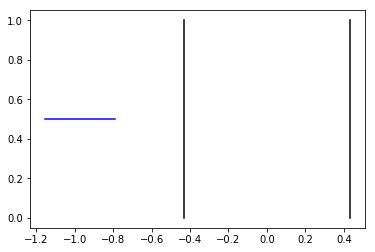

In [170]:
# TOST test
delta=0.43
m0=5.22;m1=4.25
s0=0.95;s1=0.83
n0=95;n1=89
t,p=stats.ttest_ind_from_stats(m1-delta,s1,n1,m0,s0,n0,equal_var=False)
p=(t<=0)*p/2+(1-p/2)*(t>0)
print(t,p)
t,p=stats.ttest_ind_from_stats(m1+delta,s1,n1,m0,s0,n0,equal_var=False)
p=(t>0)*p/2+(1-p/2)*(t<=0)
print(t,p)
plt.plot(2*[delta],[0,1],'k')
plt.plot(2*[-delta],[0,1],'k')
se= np.sqrt(s0**2+s1**2)/np.sqrt(n1+n0)
plt.plot([m1-m0-1.96*se,m1-m0+1.96*se],[0.5,0.5],'b')

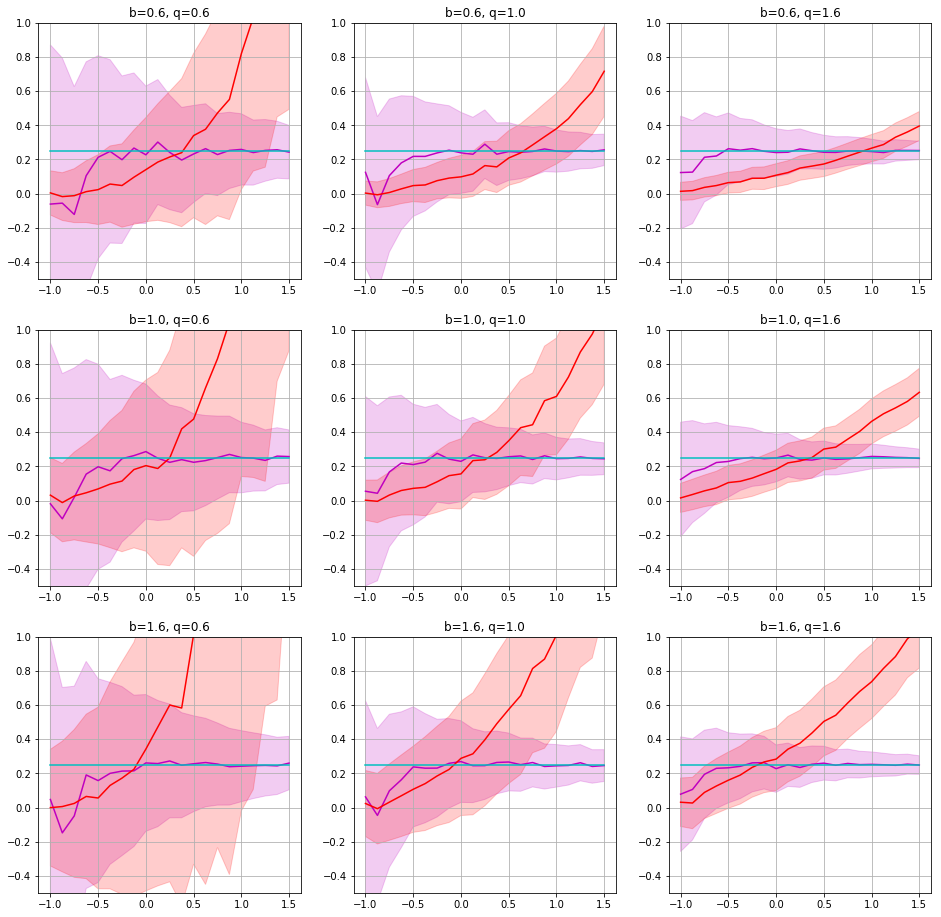

In [189]:
def plotCI(x,y,sd,df,clr='b',alpha=0.05):
    plt.grid(True)
    plt.plot(x,y,clr)
    xx=np.concatenate([x,x[::-1]])
    
    lb=y+sd*stats.t.ppf(alpha/2,df)
    ub=y+sd*stats.t.ppf(1-alpha/2,df)
    ci=np.concatenate([lb,ub[::-1]])
    
    plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
            alpha=0.2,fill=True,fc=clr,ec=clr))

plt.figure(figsize=(16,16))
yl=[1,1,1]
x=np.log(ks)
for i in range(bs.size):
    for j in range(qs.size):
        b=bs[i];q=qs[j]
        plt.subplot(bs.size,qs.size,i*qs.size+j+1)
        plt.title('b=%.1f, q=%.1f'%(b,q))
        for ii in range(2):
            d=np.median(D[i,j,:,:,2+ii*4]-D[i,j,:,:,ii*4],axis=1)
            v1=D[i,j,:,:,3+ii*4];v2=D[i,j,:,:,1+ii*4]
            sd= np.sqrt(np.median(v1+v2,axis=1))/np.sqrt(2*N)
            df=np.floor(np.square((1+np.median(v1/v2,1))/N)/
                        ((1+np.square(np.median(v1/v2,1)))/(N**2*(N-1))))
            plotCI(x,d,sd,df,['m','r'][ii])
        #plotEstim(x,D[i,j,:,:,6]-D[i,j,:,:,4],'r')
        #plt.plot(x,ks*(kinc-1),'b')
        plt.plot(x,ginc*np.ones(x.shape),'c')
        plt.ylim([-0.5,yl[j]])

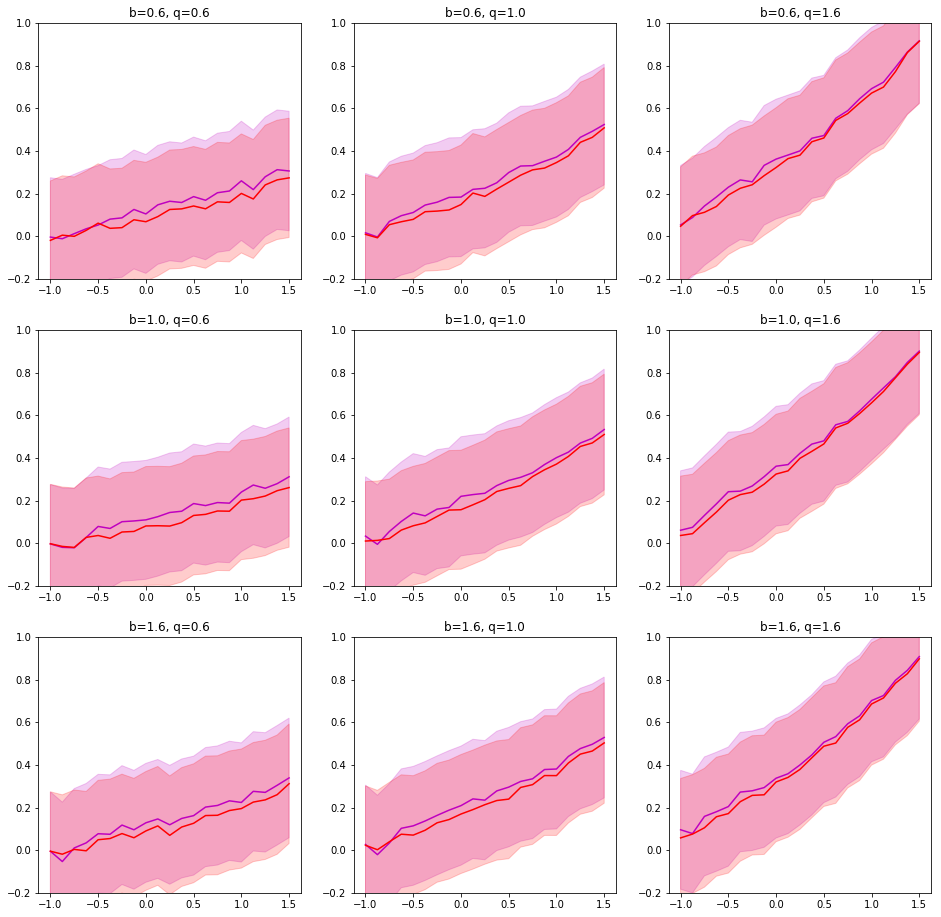

In [15]:
plt.figure(figsize=(16,16))
yl=[1,1,1]
x=np.log(ks)
for i in range(bs.size):
    for j in range(qs.size):
        b=bs[i];q=qs[j]
        plt.subplot(bs.size,qs.size,i*qs.size+j+1)
        plt.title('b=%.1f, q=%.1f'%(b,q))
        for ii in range(2):
            v1=D[i,j,:,:,3+ii*4];v2=D[i,j,:,:,1+ii*4];n=N-1;clr=['m','r'][ii]
            d=np.median((D[i,j,:,:,2+ii*4]-D[i,j,:,:,ii*4])/np.sqrt((v1+v2)/2),axis=1)
            plt.plot(x,d,clr)
            s=1.96*np.sqrt((2/N+np.square(d)/4/n)*(N/n))
            xx=np.concatenate([x,x[::-1]])
            ci=np.concatenate([d-s,(d+s)[::-1]])
            plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
                    alpha=0.2,fill=True,fc=clr,ec=clr))
        plt.ylim([-0.2,1])


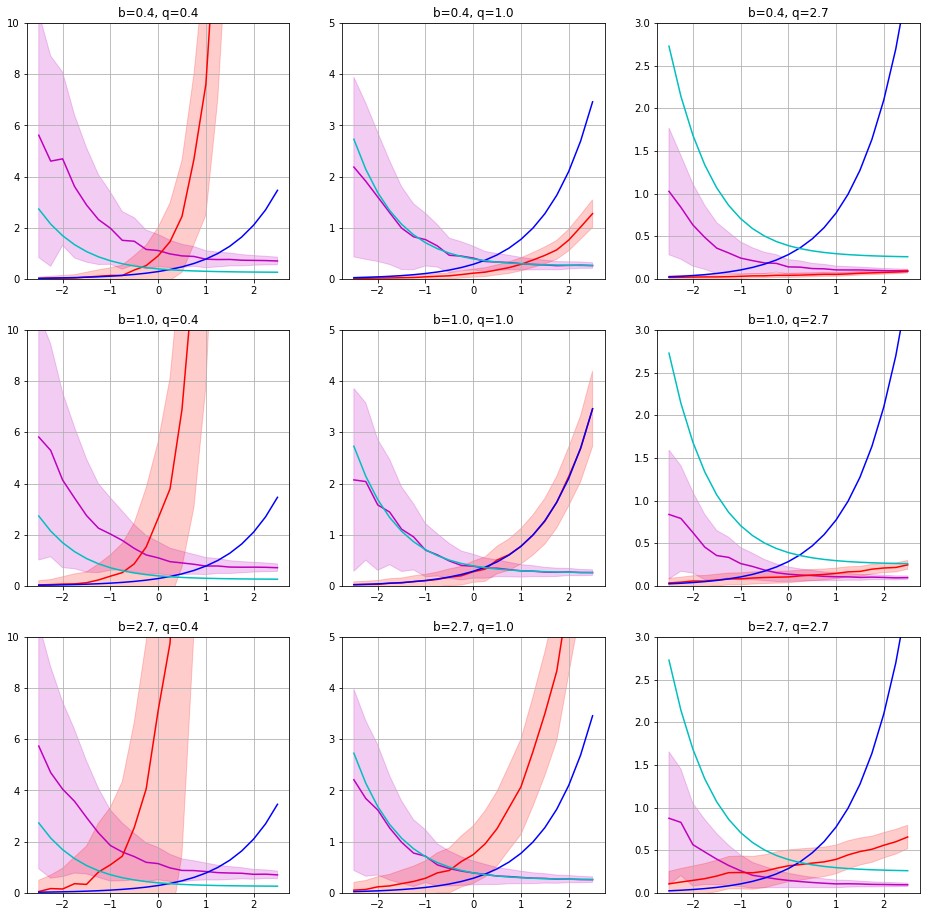

In [59]:
def plotCI(x,y,sd,df,clr='b',alpha=0.05):
    plt.grid(True)
    plt.plot(x,y,clr)
    xx=np.concatenate([x,x[::-1]])
    
    lb=y+sd*stats.t.ppf(alpha/2,df)
    ub=y+sd*stats.t.ppf(1-alpha/2,df)
    ci=np.concatenate([lb,ub[::-1]])
    
    plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
            alpha=0.2,fill=True,fc=clr,ec=clr))

plt.figure(figsize=(16,16))
yl=[10,5,3]
x=np.log(ks)
for i in range(bs.size):
    for j in range(qs.size):
        b=bs[i];q=qs[j]
        plt.subplot(bs.size,qs.size,i*qs.size+j+1)
        plt.title('b=%.1f, q=%.1f'%(b,q))
        for ii in range(2):
            d=np.median(D[i,j,:,:,2+ii*4]-D[i,j,:,:,ii*4],axis=1)
            v1=D[i,j,:,:,3+ii*4];v2=D[i,j,:,:,1+ii*4]
            sd= np.sqrt(np.median(v1+v2,axis=1))/np.sqrt(2*N)
            df=np.floor(np.square((1+np.median(v1/v2,1))/N)/
                        ((1+np.square(np.median(v1/v2,1)))/(N**2*(N-1))))
            plotCI(x,d,sd,df,['m','r'][ii])
        #plotEstim(x,D[i,j,:,:,6]-D[i,j,:,:,4],'r')
        plt.plot(x,ks*(kinc-1),'b')
        plt.plot(x,digamma(ks*kinc)-digamma(ks),'c')
        plt.ylim([0,yl[j]])

### 1.1.2 NHST

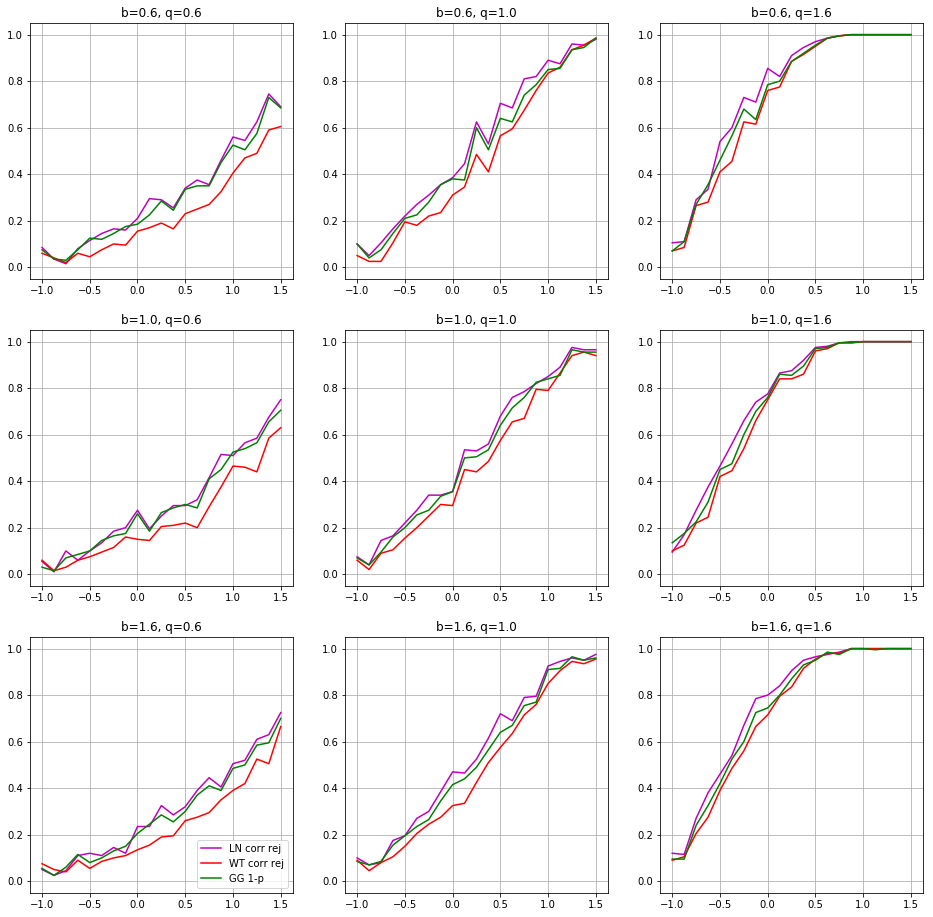

In [190]:
def welchtest(d,v1,v2,power=False):
    '''vectorized version of welch test'''
    df=np.floor(np.square((1+v1/v2)/N)/((1+np.square(v1/v2))/(N**2*(N-1))))
    denom=np.sqrt((v1+v2)/N)
    es=d/denom
    if not power: return 1-stats.t.cdf(es,df)
    else: return 1-stats.nct.cdf(0,df,es)

alpha=0.05
plt.figure(figsize=(16,16))
yl=[10,5,3]
x=np.log(ks)
for i in range(bs.size):
    for j in range(qs.size):
        b=bs[i];q=qs[j]
        plt.subplot(bs.size,qs.size,i*qs.size+j+1)
        plt.title('b=%.1f, q=%.1f'%(b,q))
        for ii in range(3):
            plt.plot(x,(D[i,j,:,:,8+ii]<alpha).mean(1),['m','r','g'][ii])
            #if ii:
            #    p=welchtest(d,D[i,j,:,:,4*ii+3],D[i,j,:,:,4*ii+1],power=True)
            #    plt.plot(x,np.median(p,1),'k')
        #k1=invdigamma((gs+ginc-np.log(b))*q)
        #k0=invdigamma((gs-np.log(b))*q)
        #m1=b*gamma(k1+1/q)/gamma(k1)
        #m0=b*gamma(k1+1/q)/gamma(k1)
        #plt.plot(x,1-welchtest(m1-m0,polygamma(1,ks),polygamma(1,ks*kinc)),'b')
        #plt.plot(x,1-welchtest(digamma(ks*kinc)-digamma(ks),
        #                     np.ones(ks.shape),np.ones(ks.shape)),'c')
        # TODO figure out CI for E[log((y/b)^q)]=digamma(k)
        plt.ylim([-0.05,1.05]) 
        if i==2 and j==0:
            plt.legend(['LN corr rej','WT corr rej','GG 1-p','MW-U'],loc=4)
        plt.grid()

# 1.1.3 TOST

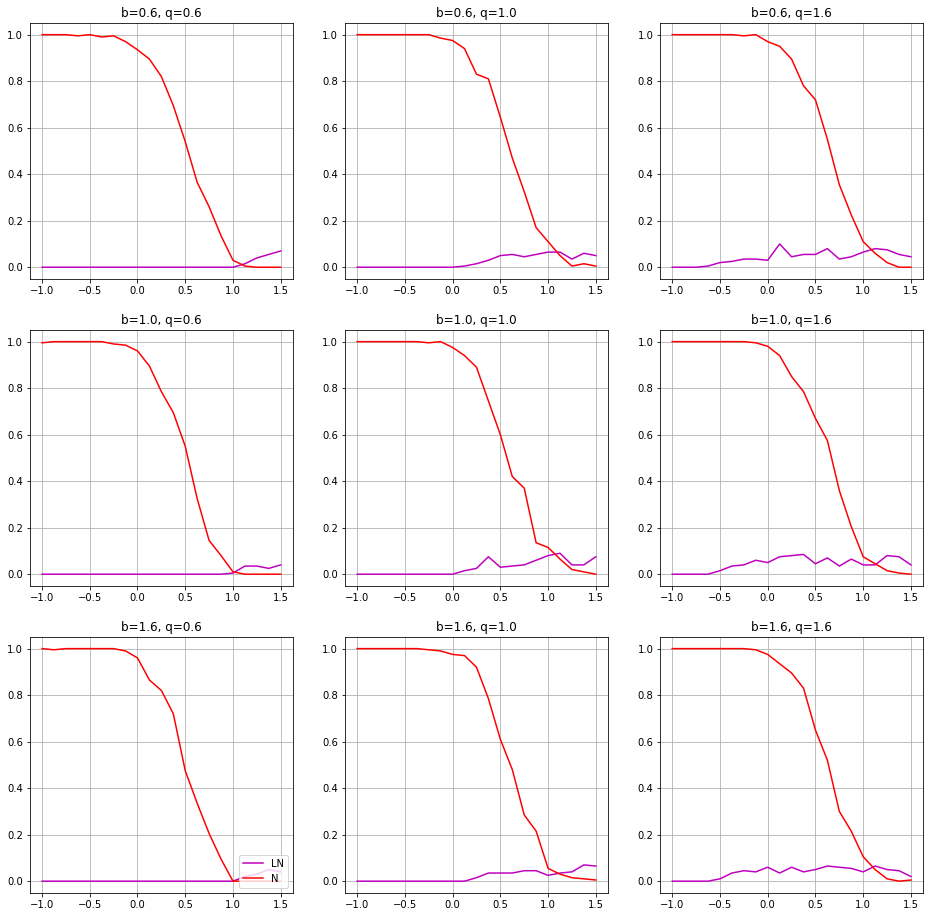

In [192]:
alpha=0.05
plt.figure(figsize=(16,16))
yl=[10,5,3]
x=np.log(ks)
for i in range(bs.size):
    for j in range(qs.size):
        b=bs[i];q=qs[j]
        plt.subplot(bs.size,qs.size,i*qs.size+j+1)
        plt.title('b=%.1f, q=%.1f'%(b,q))
        plt.plot(x,np.logical_and(D[i,j,:,:,11]<alpha,D[i,j,:,:,12]<alpha).mean(1),'m')
        plt.plot(x,np.logical_and(D[i,j,:,:,13]<alpha,D[i,j,:,:,14]<alpha).mean(1),'r')
        plt.ylim([-0.05,1.05]) 
        if i==2 and j==0:
            plt.legend(['LN','N'],loc=4)
        plt.grid()

# 1.1.4 Bayes hypothesis test

In [488]:
import pystan
sm=[] 
for i in range(2):
    model='''
data {
    int<lower=0> N; //nr subjects
    vector[N] y[2];
}parameters {
    real<lower=0,upper=10>  m;
    real<lower=0,upper=20> s[2];
    '''+['','real<lower=0,upper=10>  d;'][i]+'''
}model {
    target+=uniform_lpdf(m|0,10);
    '''+['','target+=uniform_lpdf(d|0,10);'][i]+'''
    target+=uniform_lpdf(s[1]|0,20);
    target+=uniform_lpdf(s[2]|0,20);
    for (n in 1:N){
        target+= normal_lpdf(y[1][n]|m,s[1]); 
        target+= normal_lpdf(y[2][n]|m'''+['','+d'][i]+''',s[2]); 
    } 
}'''
    sm.append(pystan.StanModel(model_code=model))

In [489]:
from scipy.stats import scoreatpercentile as sap
qs=np.exp(np.linspace(-.5,.5,3))
bs=np.exp(np.linspace(-.5,.5,3))
ks=np.exp(np.linspace(0,5,21))
ginc=0.25
N=500
D=np.zeros((bs.size,qs.size,ks.size,2,5))
#for i in range(bs.size):
#    for j in range(qs.size):
#        print(i,j)
i=1;j=1;
for h in range(ks.size):
    b=bs[i];q=qs[j];dat=[];
    k=np.array([ks[h],invdigamma(digamma(ks[h])+ginc*q)])
    for gg in range(2):
        #dat.append(stats.gengamma.rvs(k[gg],q,0,b,size=N))
        dat.append(stats.gengamma.ppf(np.linspace(0,1,N+2)[1:-1],k[gg],q,0,b))
        dat[-1][dat[-1]==0]=np.exp(-20)
    for g in range(2):
        temp={'y':[np.log(dat),dat][g],'N':N};ll=[]
        for gg in range(2):
            fit=sm[gg].sampling(data=temp,chains=6,n_jobs=6,
                    seed=7,thin=1,iter=500,warmup=200)
            print(fit)
            ll.append(fit.extract()['lp__'])
        ll=np.array(ll)
        for ii in range(5):
            D[i,j,h,g,ii]=sap(ll[:,1]-ll[:,0],[2.5,25,50,75,97.5][ii])

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m    3.7e-3  9.3e-5 3.7e-3 1.1e-4 1.1e-3 2.6e-3 5.1e-3   0.01   1561    1.0
s[0]   1.39  1.1e-3   0.04   1.31   1.36   1.39   1.42   1.48   1486    1.0
s[1]   1.18  9.4e-4   0.04   1.11   1.15   1.18    1.2   1.25   1582    1.0
lp__  -1676    0.05   1.26  -1679  -1677  -1676  -1675  -1675    659    1.0

Samples were drawn using NUTS at Thu May 10 19:29:26 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m       1.8  1.0e-3   0.04   1.71   1.77    1.8   1.83   1.88   1800    1.0
s[0]   1.27  1.1e-3   0.04   1.19   1.24   1.27    1.3   1.36   1275    1.0
s[1]    1.4  1.2e-3   0.05   1.32   1.37    1.4   1.43    1.5   1533    1.0
lp__  -1714    0.04   1.23  -1717  -1714  -1713  -1713  -1712    894    1.0

Samples were drawn using NUTS at Thu May 10 19:30:07 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m      1.24  4.2e-4   0.02   1.21   1.23   1.24   1.25   1.28   1800    1.0
s[0]   0.59  4.4e-4   0.02   0.55   0.57   0.59    0.6   0.62   1800    1.0
s[1]   0.52  4.3e-4   0.02   0.48    0.5   0.51   0.53   0.55   1457    1.0
lp__ -828.8    0.04   1.14 -831.8 -829.4 -828.5 -828.0 -827.5   1028    1.0

Samples were drawn using NUTS at Thu May 10 19:30:41 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m       6.4  2.5e-3   0.09   6.22   6.34    6.4   6.46   6.58   1315    1.0
s[0]   2.46  2.5e-3   0.08   2.31   2.41   2.46   2.52   2.62   1063    1.0
s[1]    2.8  2.6e-3   0.09   2.63   2.74    2.8   2.86   2.97   1242    1.0
lp__  -2388    0.04    1.2  -2391  -2388  -2387  -2387  -2386    922    1.0

Samples were drawn using NUTS at Thu May 10 19:31:16 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m       2.6  3.0e-4   0.01   2.58    2.6    2.6   2.61   2.63   1350    1.0
s[0]   0.32  3.7e-4   0.01    0.3   0.32   0.32   0.33   0.35    978    1.0
s[1]   0.28  3.1e-4 9.4e-3   0.26   0.27   0.28   0.28    0.3    909    1.0
lp__ -222.3    0.04   1.12 -225.1 -222.9 -222.0 -221.4 -221.0    716    1.0

Samples were drawn using NUTS at Thu May 10 19:31:56 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m      9.99  3.0e-4   0.01   9.95   9.98   9.99   10.0   10.0   1800    1.0
s[0]  11.04  9.3e-3   0.36  10.36  10.78  11.04  11.28  11.77   1516    1.0
s[1]   16.5    0.02    0.5  15.55  16.16   16.5  16.81   17.5   1062    1.0
lp__  -4030    0.05   1.27  -4033  -4030  -4029  -4029  -4028    613   1.01

Samples were drawn using NUTS at Thu May 10 19:32:42 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m      3.91  3.9e-4   0.01   3.88    3.9   3.91   3.91   3.93    732    1.0
s[0]   0.23  4.2e-4   0.01   0.21   0.22   0.23   0.24   0.25    674   1.01
s[1]   0.16  3.0e-4 7.3e-3   0.15   0.15   0.16   0.16   0.17    589    1.0
lp__ 234.02    0.05   1.19 231.06  233.4 234.34 234.92 235.42    489   1.01

Samples were drawn using NUTS at Thu May 10 19:33:31 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m      9.99  1.7e-4 5.6e-3   9.98   9.99   10.0   10.0   10.0   1134   1.01
s[0]   20.0  1.2e-4 5.0e-3  19.98  19.99   20.0   20.0   20.0   1715    1.0
s[1]   20.0  6.5e-5 2.5e-3  19.99   20.0   20.0   20.0   20.0   1543    1.0
lp__ -1.0e4    0.07   1.41 -1.0e4 -1.0e4 -1.0e4 -1.0e4 -1.0e4    438   1.01

Samples were drawn using NUTS at Thu May 10 19:34:26 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

Inference for Stan model: anon_model_a5aef21912adf828bcb75edef5242338.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m      5.13    0.06    0.1   5.02   5.03   5.13   5.22   5.23      3  22.66
s[0]   0.16    0.04   0.08   0.08   0.09   0.16   0.24   0.26      3  12.47
s[1]   0.15    0.05   0.08   0.07   0.08   0.14   0.23   0.25      3  11.62
lp__ 547.38   14.25  24.68 520.26 523.07 545.12 572.35  573.4      3  20.87

Samples were drawn using NUTS at Thu May 10 19:35:21 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_20007c6100db86c6c7b7439e5b8e2468.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

       mean se_mean     s

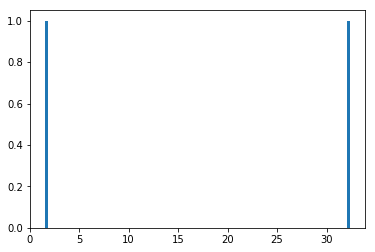

In [481]:
plt.hist(np.exp(),bins=100);

(0, 1)

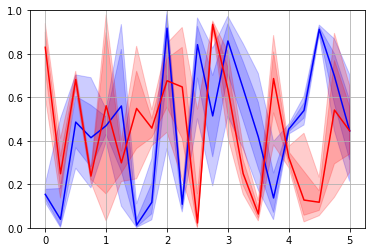

In [490]:
def plotCI(x,y,la,ua,lb,ub,clr='b'):
    plt.grid(True)
    plt.plot(x,y,clr)
    xx=np.concatenate([x,x[::-1]])
    ci=np.concatenate([lb,ub[::-1]])
    plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
            alpha=0.2,fill=True,fc=clr,ec=clr))
    ci=np.concatenate([la,ua[::-1]])
    plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
            alpha=0.2,fill=True,fc=clr,ec=clr))
Dd=1/(1+np.exp(-D))
for g in range(2):
    plotCI(np.log(ks),Dd[1,1,:,g,2],Dd[1,1,:,g,0],Dd[1,1,:,g,4],Dd[1,1,:,g,1],Dd[1,1,:,g,3],clr=['b','r'][g])
plt.ylim([0,1])

# 1.4.2 Bayes Hyp t-Test  

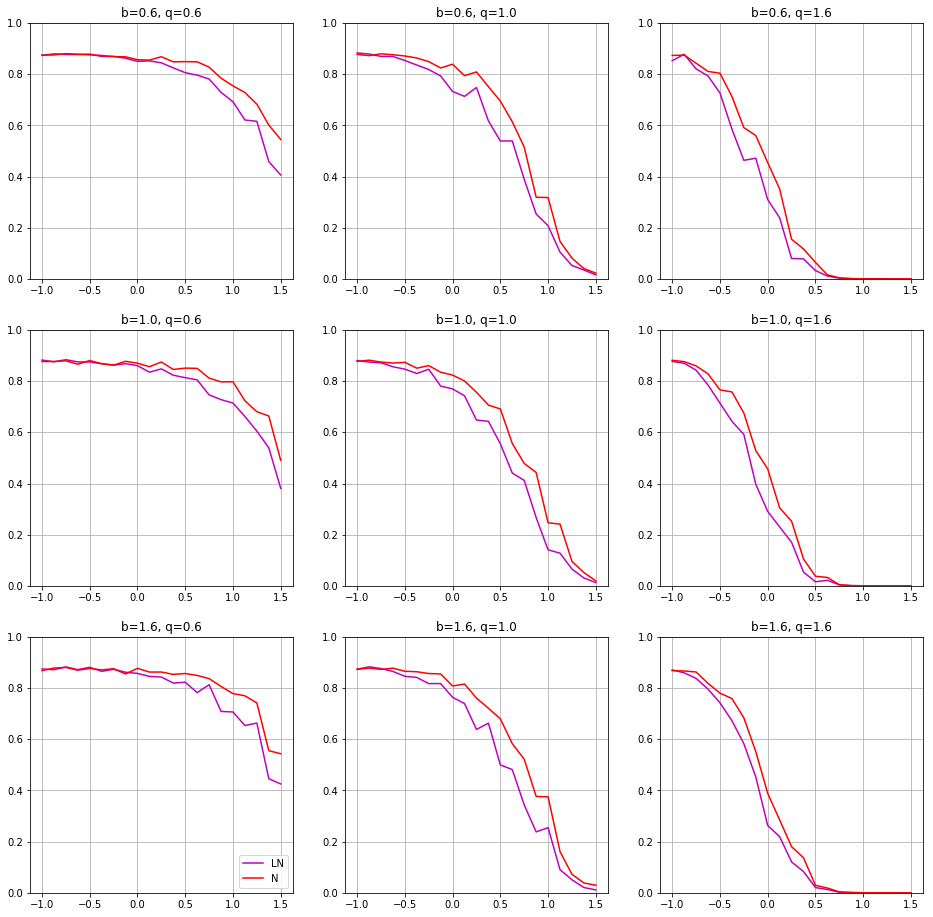

In [27]:
alpha=0.05
plt.figure(figsize=(16,16))
yl=[10,5,3]
x=np.log(ks)
for i in range(bs.size):
    for j in range(qs.size):
        b=bs[i];q=qs[j]
        plt.subplot(bs.size,qs.size,i*qs.size+j+1)
        plt.title('b=%.1f, q=%.1f'%(b,q))
        plt.plot(x,np.median(D[i,j,:,:,15]/(1+D[i,j,:,:,15]),axis=1),'m')
        plt.plot(x,np.median(D[i,j,:,:,16]/(1+D[i,j,:,:,16]),axis=1),'r')
        plt.ylim([-0,1]) 
        if i==2 and j==0:
            plt.legend(['LN','N'],loc=4)
        plt.grid()
        
# bridge sampling

### 1.1.4 NHST and sample size

In [71]:
ns=np.array([10,20,50])
b=1;q=1;
D=np.zeros((ns.size,ks.size,R,3))
for n in range(ns.size):
    print(n)
    for r in range(R):
        for h in range(ks.size):
            dat0=stats.gengamma.rvs(ks[h],q,0,b,size=ns[n])
            k=invdigamma(digamma(ks[h])+ginc*q)
            dat1=stats.gengamma.rvs(k,q,0,b,size=ns[n])
            dat0[dat0==0]=np.exp(-20);dat1[dat1==0]=np.exp(-20) 
            D[n,h,r,0]=stats.ttest_ind(np.log(dat0),np.log(dat1),equal_var=False)[1]/2
            D[n,h,r,1]=stats.ttest_ind(dat0,dat1,equal_var=False)[1]/2
            D[n,h,r,2]=stats.mannwhitneyu(dat0,dat1,alternative='less')[1]

0
1
2


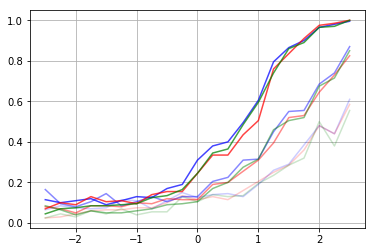

In [72]:
for n in range(ns.size):
    for ii in range(D.shape[-1]):
        plt.plot(x,(D[n,:,:,ii]<alpha).mean(1),
            ['b','r','g'][ii],alpha=0.2+0.8*n/ns.size)
plt.grid()
#plt.ylim([0,1]) 

## 1.2 Three groups

### 1.2.1 NHST

In [54]:
N=66
R=200
ks=np.exp(np.linspace(-1.5,1.5,21))
D=np.zeros((bs.size,qs.size,ks.size,R,3))

for i in range(bs.size):
    for j in range(qs.size):
        print(i,j)
        for r in range(R):
            for h in range(ks.size):
                b=bs[i];q=qs[j];dat=[]
                for g in range(3):
                    k=invdigamma(digamma(ks[h])+g*ginc*q)
                    #k=ks[h]*np.exp(g*ginc)
                    dat.append(stats.gengamma.rvs(k,q,0,b,size=N))
                    dat[-1][dat[-1]==0]=np.exp(-20);
                D[i,j,h,r,0]=stats.f_oneway(*list(map(np.log,dat)))[1]
                D[i,j,h,r,1]=stats.f_oneway(*dat)[1]
                D[i,j,h,r,2]=stats.kruskal(*dat)[1]

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 535, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 520, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt


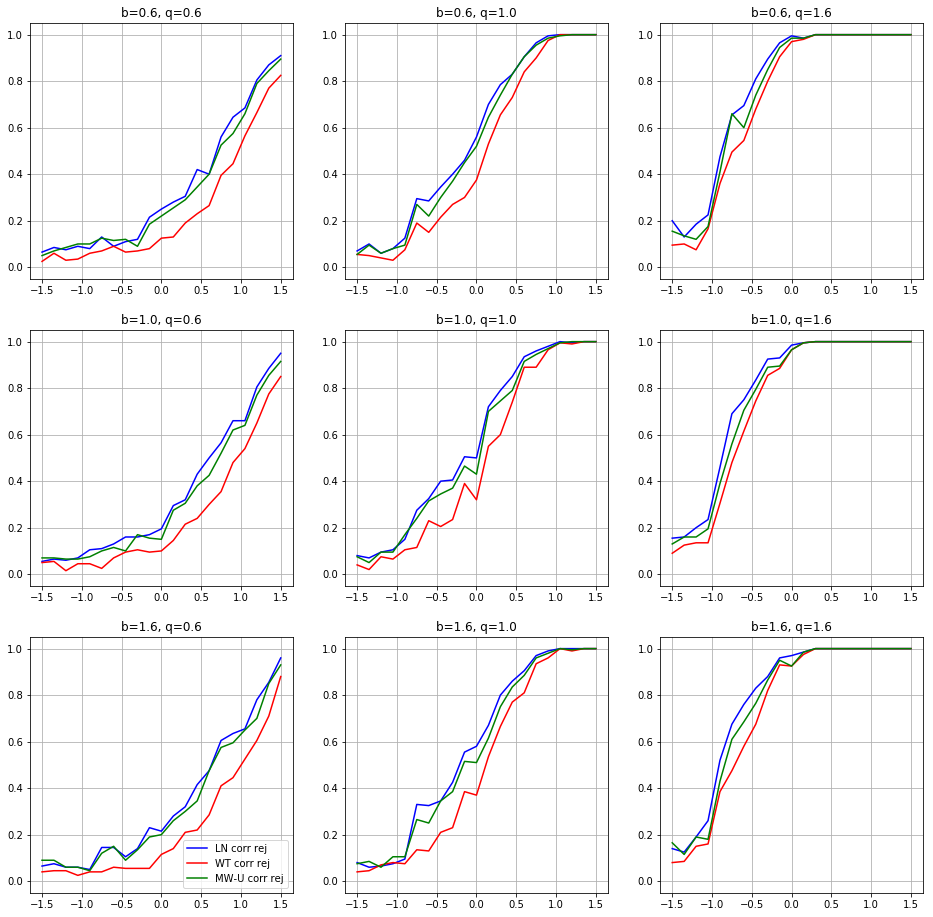

In [55]:
alpha=0.05
plt.figure(figsize=(16,16))
yl=[10,5,3]
x=np.log(ks)
for i in range(bs.size):
    for j in range(qs.size):
        b=bs[i];q=qs[j]
        plt.subplot(bs.size,qs.size,i*qs.size+j+1)
        plt.title('b=%.1f, q=%.1f'%(b,q))
        plt.plot(x,(D[i,j,:,:,0]<alpha).mean(1),'b')
        plt.plot(x,(D[i,j,:,:,1]<alpha).mean(1),'r')
        plt.plot(x,(D[i,j,:,:,2]<alpha).mean(1),'g')
        plt.ylim([-0.05,1.05]) 
        if i==2 and j==0:
            plt.legend(['LN corr rej','WT corr rej','MW-U corr rej'],loc=4)
        plt.grid()

# 1.2.2 Equiv. test 3 groups

In [9]:
def anova3groups(y,es=0):
    '''
    returns p value
    nreps=1000
    alpha=0.05
    temp=np.zeros((nreps,5,3))
    for g in range(3):
        #print(es,offset,g)
        temp[:,:,g]=orderedLogitRvs(0+(g-1)*1,np.array([-3,-1,1,3]),50,size=nreps)
    y=reformatData(temp)
    out=anova3groups(y,alpha)
    '''
    N=int(y.shape[0]/3)
    #if not equi: fcrit=stats.f.ppf(1-alpha,2,3*N-3)
    #else: fcrit=ncfdtri(2,3*N-3,esH1**2*3*N,alpha)
    x=np.zeros((N*3,3))
    for i in range(0,3):
            x[i*N:(i+1)*N,i]=1
    ss=np.zeros((2,y.shape[1]))
    ss[1,:]=np.linalg.lstsq(x,y)[1]
    tot=np.square(y-np.atleast_2d(y.mean(0))).sum(0)
    ss[0,:]=tot-ss[1,:]
    mss=ss/np.float32(np.array([2,3*N-3],ndmin=2).T)
    #print(fcrit,mss[0,0],mss[1,0])
    #np.nanmean(np.int32(fcrit<mss[0,:]/mss[1,:]))
    #if es==-1: es=1
    if not es: p=1-stats.f.cdf(mss[0,:]/mss[1,:],2,3*N-3)
    else: p=ncfdtr(2,3*N-3,es**2*3*N,mss[0,:]/mss[1,:])
    return p

nreps=1000
alpha=0.05
N=50
temp=np.zeros((3*N,nreps))
es=0.8
for g in range(3):
    #print(es,offset,g)
    temp[g*N:(g+1)*N,:]=(g-1)*np.sqrt(3/2)*es+np.random.randn(N,nreps)
p=anova3groups(temp,es=1.2)
np.nanmean(np.int32(p<alpha))

0.99399999999999999

In [10]:
N=66
R=200
ks=np.exp(np.linspace(-1.5,1.5,21))
b=bs[1];q=qs[1];
D=np.zeros((ks.size,R,2))
ef=[0.28,0.268]
for h in range(ks.size)[::-1]:
    dat=[]
    for r in range(R):    
        temp=[]
        for g in range(3):
            k=invdigamma(digamma(ks[h])+g*ginc*q)
            temp.extend(stats.gengamma.rvs(k,q,0,b,size=N))
        dat.append(temp)  
    dat=np.array(dat).T
    dat[dat==0]=np.exp(-20);
    D[h,:,0]=anova3groups(np.log(dat),es=ef[0]) 
    D[h,:,1]=anova3groups(dat,es=ef[1]) 

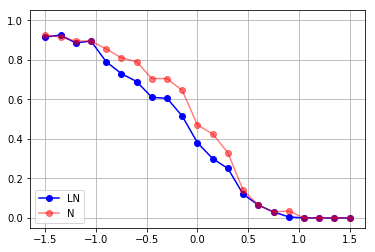

In [15]:
alpha=0.05
#plt.figure(figsize=(16,16))
yl=[10,5,3]
x=np.log(ks)
plt.plot(x,(D[:,:,0]<alpha).mean(1),'bo-')
plt.plot(x,(D[:,:,1]<alpha).mean(1),'ro-',alpha=0.5)
plt.ylim([-0.05,1.05]) 
plt.legend(['LN','N'],loc=3)
plt.grid()

# 1.3.1 Factor design 2x2

(array([[ 0.00003551,  0.07412432,  0.24293399]]),
 array([[  0.65572056,  14.59264   ,   2.21841   ,   0.92416   ]]))

(1, 3, 15)

array([[ 0.00011854,  0.21764335,  0.23336913]])

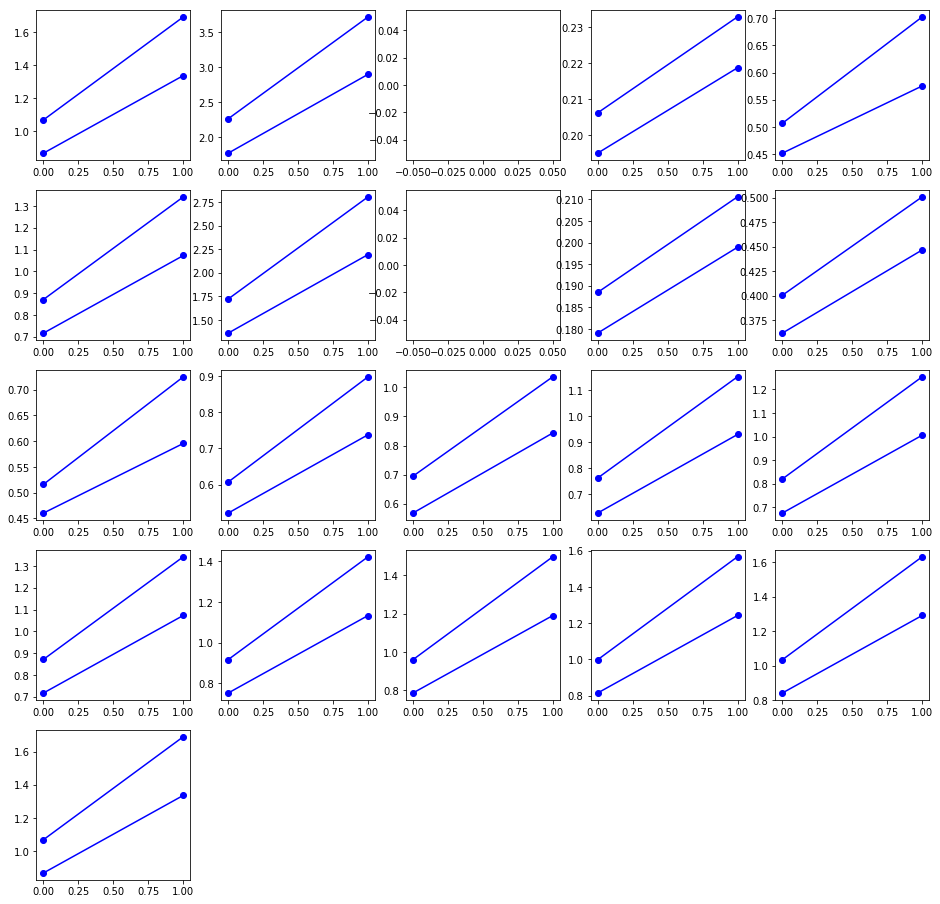

In [18]:
qs=np.exp(np.linspace(-1,1,3))
bs=np.exp(np.linspace(-1,1,3))
ks=np.linspace(-1.5,2.5,21)
ginc=np.array([-0.5,0,-0.25,0.25])
N=100
R=200
plt.figure(figsize=(16,16))
q=qs[-1]
for i in range(ks.size):
    plt.subplot(5,5,i+1)
    k=invdigamma(digamma(ks[i])+ginc[:2]*q)
    plt.plot(gamma(k+1/q)/gamma(k),'bo-');
    k=invdigamma(digamma(ks[i])+ginc[2:]*q)
    plt.plot(gamma(k+1/q)/gamma(k),'bo-');
    #plt.xlim([0,1])

In [25]:
qs=np.exp(np.linspace(-1,1,3))
bs=np.exp(np.linspace(-1,1,3))
ks=np.exp(np.linspace(-1.5,2.5,21))
ginc=np.array([-1,0,-0.5,0.5])
N=50
R=200

D=np.zeros((bs.size,qs.size,ks.size,R,9))
for i in range(bs.size):
    for j in range(qs.size):
        print(i,j)
        for h in range(ks.size):
            b=bs[i];q=qs[j];gm=digamma(ks[h]);dat=[]       
            for g in range(4):
                k=invdigamma(gm+ginc[g]*q)
                dat.append(stats.gengamma.rvs(k,q,0,b,size=(N,R)))
                dat[-1][dat[-1]==0]=np.exp(-20)
            D[i,j,h,:,:3]=anova2Bx2B(np.array(np.log(dat)).T)[0]
            D[i,j,h,:,3:6]=anova2Bx2B(np.array(dat).T)[0]
            D[i,j,h,:,6:9]=scheirerRayHare2Bx2B(np.array(dat).T)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


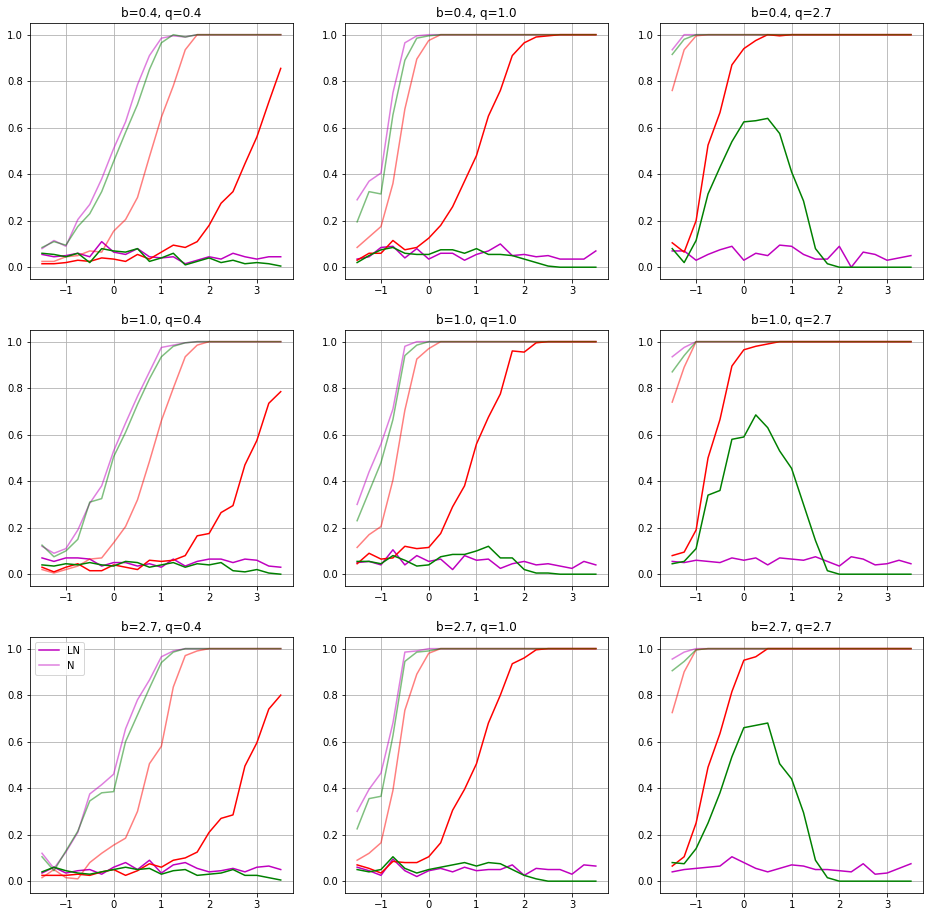

In [24]:
alpha=0.05
plt.figure(figsize=(16,16))
x=np.log(ks)
for i in range(bs.size):
    for j in range(qs.size):
        b=bs[i];q=qs[j]
        plt.subplot(bs.size,qs.size,i*qs.size+j+1)
        plt.title('b=%.1f, q=%.1f'%(b,q))
        for ii in range(3):
            plt.plot(x,(D[i,j,:,:,ii*3+2]<alpha).mean(1),['m','r','g'][ii])
            plt.plot(x,(D[i,j,:,:,ii*3+1]<alpha).mean(1),['m','r','g'][ii],alpha=0.5)
        plt.ylim([-0.05,1.05]) 
        if i==2 and j==0:
            plt.legend(['LN','N'],loc=0)
        plt.grid()

# Check mean sum of squares

In [90]:
ks=np.exp(np.linspace(-1.5,1.5,21))
ginc=np.array([-1,0,-0.5,0.5])
N=100
R=200
D=np.zeros((ks.size,R,8))
for h in range(ks.size):
    b=1;q=1;gm=digamma(ks[h]);dat=[]       
    for g in range(4):
        k=invdigamma(gm+ginc[g]*q)
        dat.append(stats.gengamma.rvs(k,q,0,b,size=(N,R)))
        dat[-1][dat[-1]==0]=np.exp(-20)
    D[h,:,:4]=anova2Bx2B(np.array(np.log(dat)).T)[1]
    if np.any(D[h,:,:4]<0):bla
    D[h,:,4:8]=anova2Bx2B(np.array(dat).T)[1]

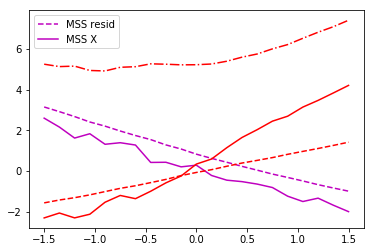

In [96]:
x=np.log(ks)
plt.plot(x,np.log(np.median(D[:,:,0],axis=1)),'m--')
plt.plot(x,np.log(np.median(D[:,:,3],axis=1)),'m-')
plt.plot(x,np.log(np.median(D[:,:,4],axis=1)),'r--')
plt.plot(x,np.log(np.median(D[:,:,7],axis=1)),'r-')
plt.plot(x,np.log(np.median(D[:,:,:].sum(2),axis=1)),'r-.')
plt.legend(['MSS resid','MSS X'])

# Continuous Floor and Ceiling

## Two groups

### Estimation

In [263]:

def ab2gg(a,b):
    temp=digamma(a+b)
    return digamma(a)-temp,digamma(b)-temp


def gg2ab(g1,g2):
    # init conditions Lau and Lau (1991)
    #a=np.exp(-3.929+10.523*np.exp(g2)-3.026*np.power(np.exp(g1),3)
    #         +1.757*np.exp(np.exp(g2)*np.sqrt(np.exp(g1))))
    #b=np.exp(-3.895+1.222*np.sqrt(g2)-6.9056*np.power(np.exp(g1),3))
    t1=np.exp(g1);t2=np.exp(g2)
    #print(t1,t2)
    a=0.5*(1+t1-t2)/(1-t1-t2);b=0.5*(1+t2-t1)/(1-t1-t2)
    ab=np.array([a,b])
    ggt=np.array([g1,g2])
    ggc=np.array(ab2gg(ab[0],ab[1]))
    crit=np.linalg.norm(ggt-ggc)
    #print(crit,ab)
    while crit>1e-10:
        temp=polygamma(1,ab[0]+ab[1])
        J=np.array([[(polygamma(1,ab[0])-temp)*ab[0],-temp*ab[1]],
                    [-ab[0]*temp,ab[1]*(polygamma(1,ab[1])-temp)]])
        ab=np.exp(np.log(ab)-np.linalg.inv(J).dot(ggc-ggt))
        ggc=ab2gg(ab[0],ab[1])
        crit=np.linalg.norm(ggt-ggc)
        #print(crit,ab)
    return ab[0],ab[1]
#gg=np.array(ab2gg(5,1))
#gg2ab(gg[0],gg[1])
gg2ab(gas[j],gbs[h]+ginc*g)

(nan, nan)

In [282]:
np.exp(-3)

0.049787068367863944

-0.051293294387550578

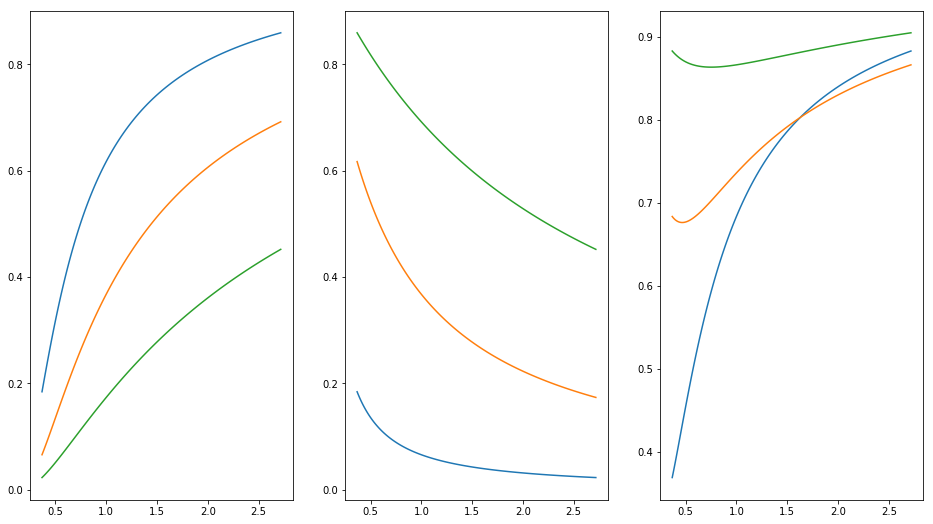

In [246]:
plt.figure(figsize=(16,9))
a=np.exp(np.linspace(-1,1,101))
for b in list(np.exp(np.linspace(-1,1,3))):
    res=ab2gg(a,b)
    plt.subplot(1,3,1)
    plt.plot(a,np.exp(res[0]))
    plt.subplot(1,3,2)
    plt.plot(a,np.exp(res[1]))
    plt.subplot(1,3,3)
    plt.plot(a,np.exp(res[0])+np.exp(res[1]))
log(0.95)

In [519]:
bs=np.exp(np.linspace(-1,1,3))
gas=np.linspace(-1.2,-0.41,3)
gbs=np.linspace(-4,-1.1,11)#np.linspace(-4,-0.7,21)
ginc=-1
N=100
R=200
D=np.zeros((bs.size,gas.size,gbs.size,R,17))
# TOST threshold
ta=int(gas.size/2);tb=int(gbs.size/2)
tmp1=gg2ab(gas[ta],gbs[tb])
tmp2=gg2ab(gas[ta],gbs[tb]+ginc)
delta=-np.array([ginc,tmp1[0]/(tmp1[1]+tmp1[0])-tmp2[0]/(tmp2[1]+tmp2[0])])
for i in range(bs.size):
    print(i)
    for j in range(gas.size):
        for r in range(R):
            for h in range(gbs.size):
                dat=[];
                if np.exp(gas[j])+np.exp(gbs[h])>1:
                    D[i,j,h,r,:]=np.nan
                    continue
                for g in range(2):
                    a,b=gg2ab(gas[j],gbs[h]+ginc*g)
                    dat.append(stats.beta.rvs(a,b,0,bs[i],size=N))
                    dat[-1][dat[-1]==bs[i]]=bs[i]-np.exp(-20)
                    dat[-1][dat[-1]==0]=np.exp(-20)
                    D[i,j,h,r,[2*g,2*g+1]]=[np.mean(logit(dat[-1]/bs[i])),
                                            np.var(logit(dat[-1]/bs[i]),ddof=1)]
                    D[i,j,h,r,[2*g+4,2*g+5]]=[np.mean(dat[-1]),np.var(dat[-1],ddof=1)]
                ts=[]
                for g in range(2):
                    t,p=stats.ttest_ind_from_stats(D[i,j,h,r,2+g*4],
                            np.sqrt(D[i,j,h,r,3+g*4]),N, D[i,j,h,r,g*4],
                            np.sqrt(D[i,j,h,r,1+g*4]),N, equal_var=False)
                    D[i,j,h,r,8+g]=(t>0)*p/2+(1-p/2)*(t<=0)
                    # bayes factor in favor of no difference
                    t,p=stats.ttest_ind_from_stats(D[i,j,h,r,2+g*4],
                            np.sqrt(D[i,j,h,r,3+g*4]),N, D[i,j,h,r,g*4],
                            np.sqrt(D[i,j,h,r,1+g*4]),N, equal_var=True)
                    nn=N/2;v=2*N-2
                    f=lambda g:(2*np.pi*(1+nn*g))**-0.5*((1+(t**2)/(1+nn*g)/v)**(-(v+1)/2)*g**-1.5*np.exp(-1/2/g))
                    denom=quad(f,0,np.inf)[0]
                    D[i,j,h,r,15+g]=(1+t**2/v)**(-(v+1)/2)/denom
                D[i,j,h,r,10]=stats.mannwhitneyu(dat[0],dat[1],alternative='less')[1]
                #TOST
                for g in range(2):
                    for gg in range(2):
                        t,p=stats.ttest_ind_from_stats(D[i,j,h,r,g*4+2]+[-1,1][gg]*delta[g],
                                                       np.sqrt(D[i,j,h,r,g*4+3]),N,
                            D[i,j,h,r,g*4],np.sqrt(D[i,j,h,r,g*4+1]),N, equal_var=False)
                        D[i,j,h,r,11+gg+g*2]=[(t<=0)*p/2+(1-p/2)*(t>0),(t>0)*p/2+(1-p/2)*(t<=0)][gg]


0
1
2


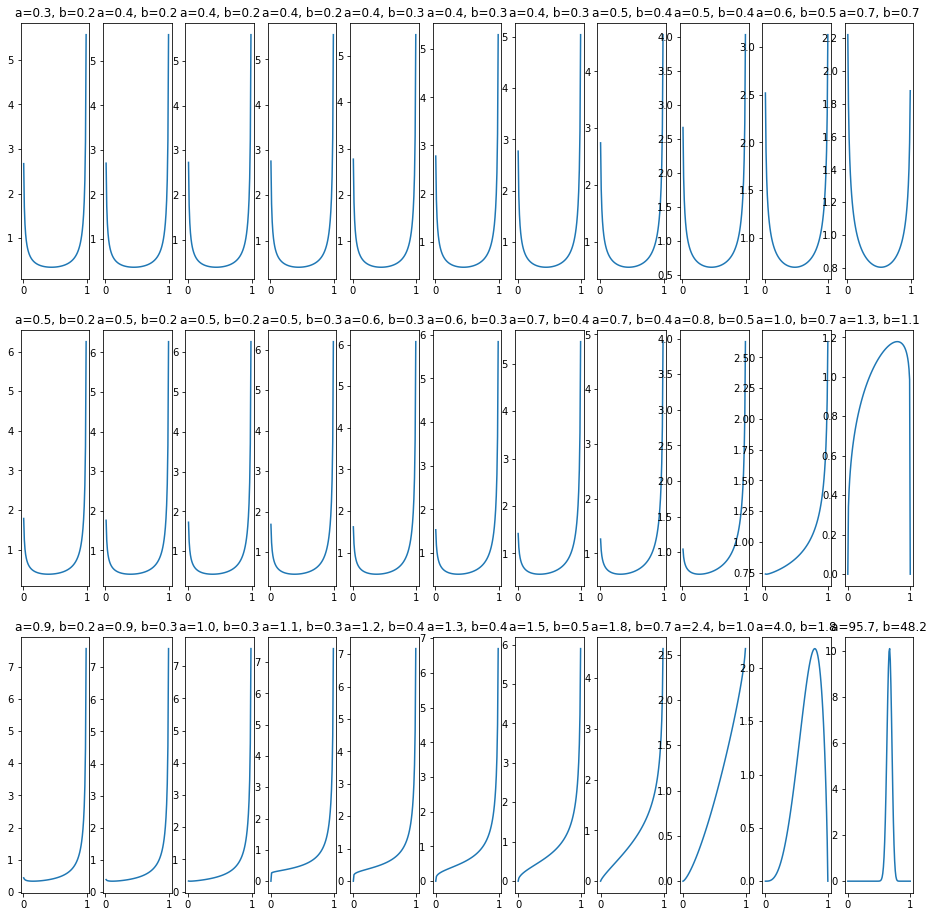

In [520]:
plt.figure(figsize=(16,16))
for i in range(gas.size):
    for j in range(gbs.size):
        plt.subplot(gas.size,gbs.size,i*gbs.size+j+1)
        a,b=gg2ab(gas[i],gbs[j])
        x=np.linspace(0,1,101)
        plt.plot(x,stats.beta.pdf(x,a,b))
        plt.title('a=%.1f, b=%.1f'%(a,b))

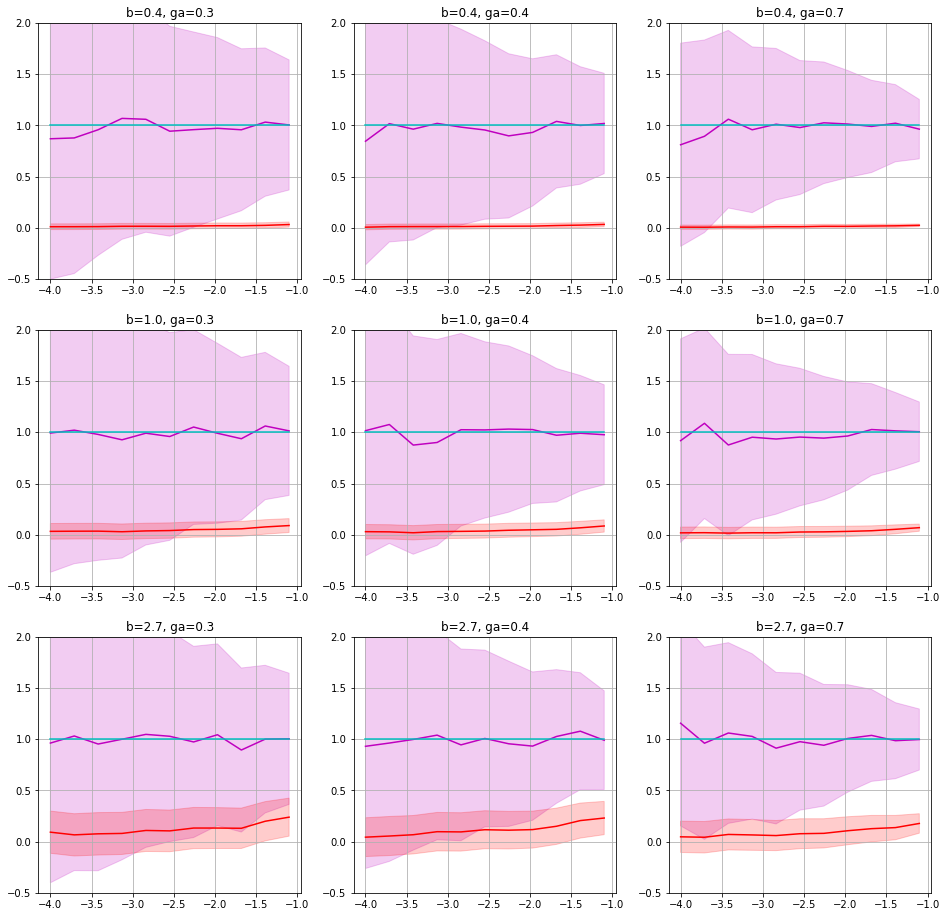

In [510]:
def plotCI(x,y,sd,df,clr='b',alpha=0.05):
    sel=np.isnan(y)
    if np.any(sel):
        x=x[~sel];y=y[~sel];sd=sd[~sel];df=df[~sel]
    plt.grid(True)
    plt.plot(x,y,clr)
    xx=np.concatenate([x,x[::-1]])
    
    lb=y+sd*stats.t.ppf(alpha/2,df)
    ub=y+sd*stats.t.ppf(1-alpha/2,df)
    ci=np.concatenate([lb,ub[::-1]])
    #print(ci)
    plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
            alpha=0.2,fill=True,fc=clr,ec=clr))

plt.figure(figsize=(16,16))
yl=[1,1,1]
x=gbs
for i in range(bs.size):
    for j in range(gas.size):
        beta=bs[i];a=gas[j]
        plt.subplot(bs.size,gas.size,i*gas.size+j+1)
        plt.title('b=%.1f, ga=%.1f'%(beta,np.exp(a)))
        for ii in range(2):
            d=np.nanmedian(D[i,j,:,:,2+ii*4]-D[i,j,:,:,ii*4],axis=1)
            v1=D[i,j,:,:,3+ii*4];v2=D[i,j,:,:,1+ii*4]
            sd= np.sqrt(np.nanmedian(v1+v2,axis=1))/np.sqrt(2*N)
            df=np.floor(np.square((1+np.nanmedian(v1/v2,1))/N)/
                        ((1+np.square(np.nanmedian(v1/v2,1)))/(N**2*(N-1))))
            plotCI(x,d,sd,df,['m','r'][ii])
        #plotEstim(x,D[i,j,:,:,6]-D[i,j,:,:,4],'r')
        #plt.plot(x,ks*(kinc-1),'b')
        plt.plot(x,-ginc*np.ones(x.shape),'c')
        #plt.ylim([-0.5,yl[j]])
        plt.ylim([-.5,2])

## Hypothesis Testing

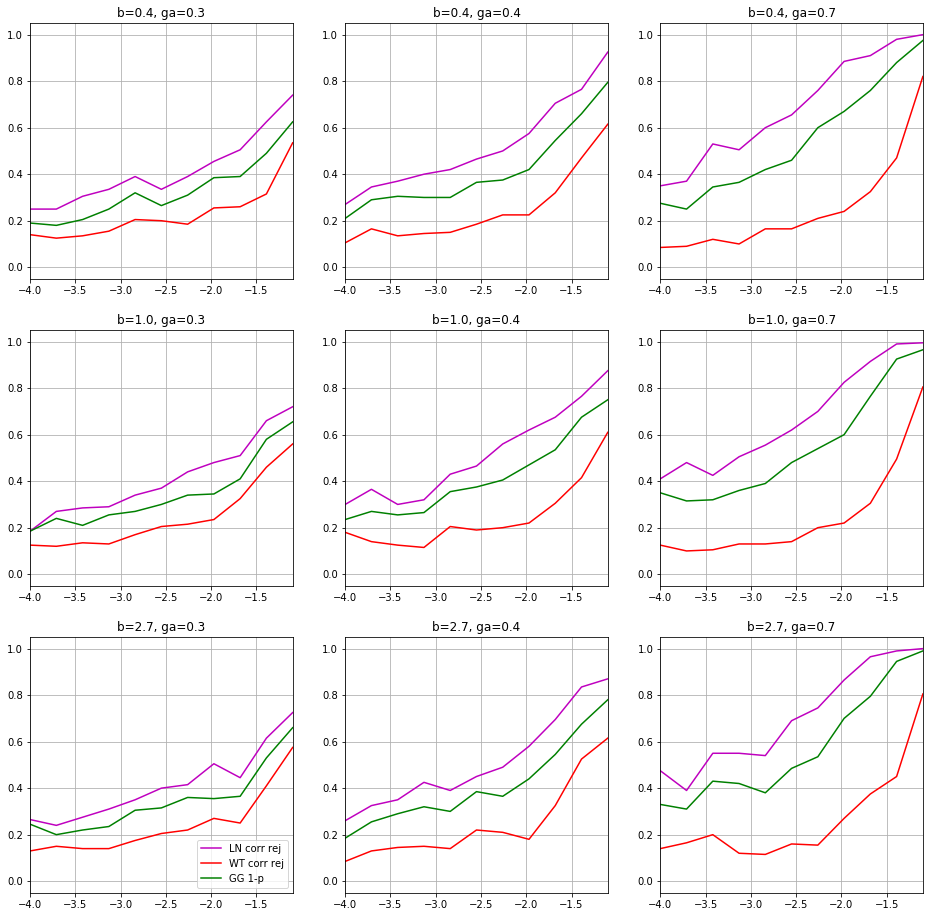

In [511]:
alpha=0.05
plt.figure(figsize=(16,16))
x=gbs
for i in range(bs.size):
    for j in range(gas.size):
        b=bs[i];ga=gas[j]
        plt.subplot(bs.size,gas.size,i*gas.size+j+1)
        plt.title('b=%.1f, ga=%.1f'%(b,np.exp(ga)))
        for ii in range(3):
            sel=~np.all(np.isnan(D[i,j,:,:,8+ii]),axis=1)
            plt.plot(x[sel],(D[i,j,:,:,8+ii]<alpha).mean(1)[sel],['m','r','g'][ii])
        plt.xlim([np.min(x),np.max(x)])
        plt.ylim([-0.05,1.05]) 
        if i==2 and j==0:
            plt.legend(['LN corr rej','WT corr rej','GG 1-p','MW-U'],loc=4)
        plt.grid()

array([ 1.        ,  0.03883839])

## TOST

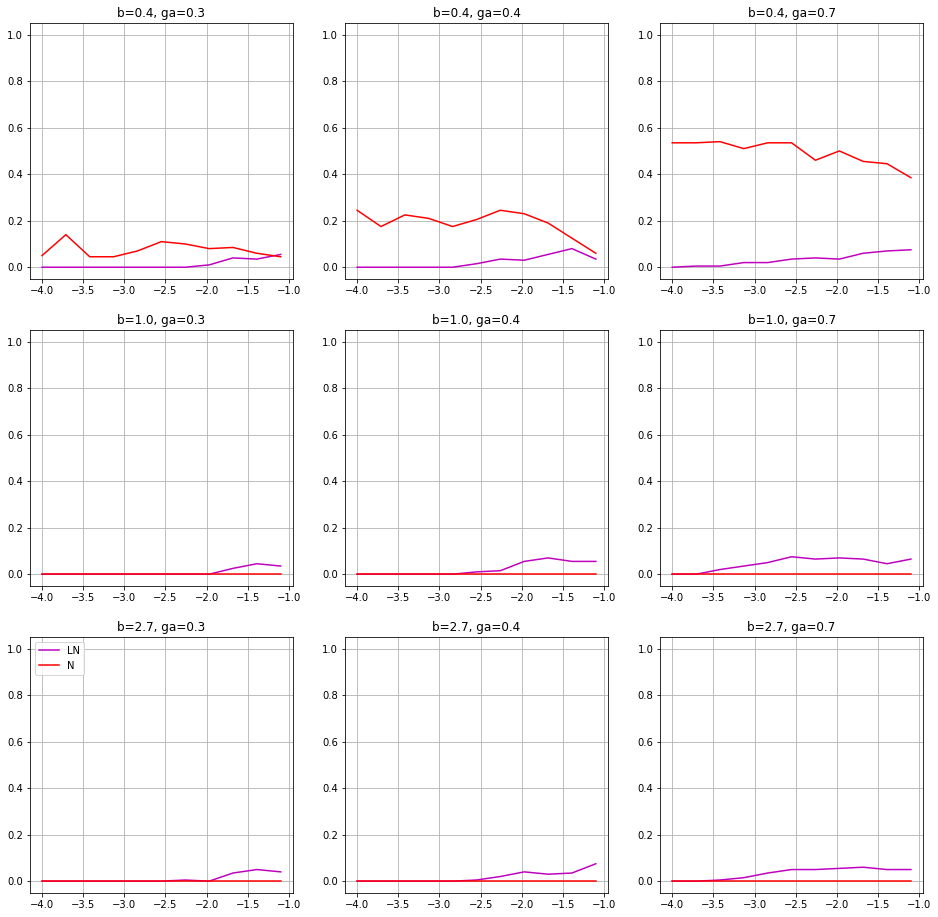

In [512]:
alpha=0.05
plt.figure(figsize=(16,16))
x=gbs
for i in range(bs.size):
    for j in range(gas.size):
        b=bs[i];ga=gas[j]
        plt.subplot(bs.size,gas.size,i*gas.size+j+1)
        plt.title('b=%.1f, ga=%.1f'%(b,np.exp(ga)))
        sel=~np.all(np.isnan(D[i,j,:,:,11]),axis=1)
        plt.plot(x[sel],np.logical_and(D[i,j,:,:,11]<alpha,D[i,j,:,:,12]<alpha).mean(1)[sel],'m')
        plt.plot(x[sel],np.logical_and(D[i,j,:,:,13]<alpha,D[i,j,:,:,14]<alpha).mean(1)[sel],'r')
        plt.ylim([-0.05,1.05]) 
        if i==2 and j==0:
            plt.legend(['LN','N'],loc=2)
        plt.grid()

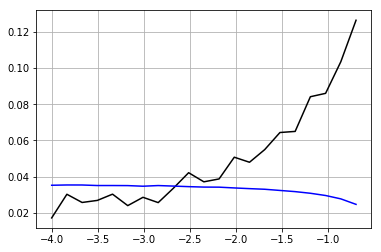

In [416]:
i=1;j=1;ii=1
d=np.nanmedian(D[i,j,:,:,2+ii*4]-D[i,j,:,:,ii*4],axis=1)
v1=D[i,j,:,:,3+ii*4];v2=D[i,j,:,:,1+ii*4]
sd= np.sqrt(np.nanmedian(v1+v2,axis=1))/np.sqrt(2*N)
plt.plot(x,d,'k')
plt.plot(x,sd,'b')
plt.grid(1)

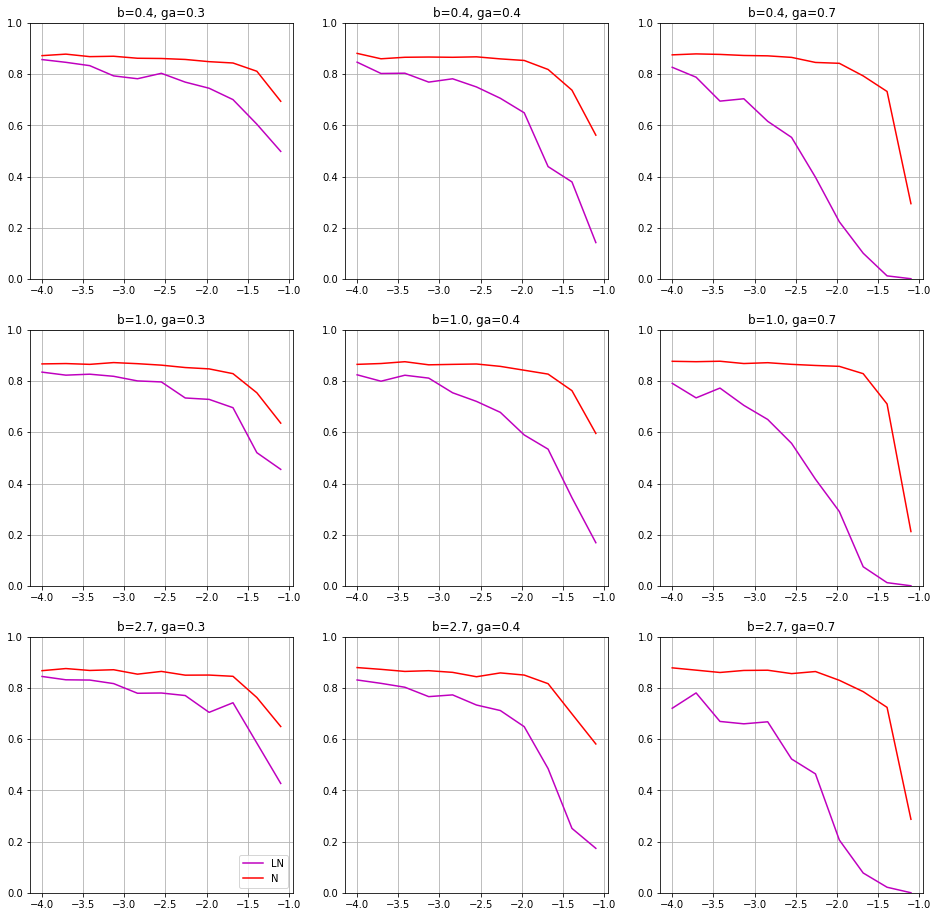

In [513]:
alpha=0.05
plt.figure(figsize=(16,16))
x=gbs
for i in range(bs.size):
    for j in range(gas.size):
        b=bs[i];ga=gas[j]
        plt.subplot(bs.size,gas.size,i*gas.size+j+1)
        plt.title('b=%.1f, ga=%.1f'%(b,np.exp(ga)))
        plt.plot(x,np.nanmedian(D[i,j,:,:,15]/(1+D[i,j,:,:,15]),axis=1),'m')
        plt.plot(x,np.nanmedian(D[i,j,:,:,16]/(1+D[i,j,:,:,16]),axis=1),'r')
        plt.ylim([-0,1]) 
        if i==2 and j==0:
            plt.legend(['LN','N'],loc=4)
        plt.grid()

# Anova 2x2

In [514]:

    

bs=np.exp(np.linspace(-1,1,3))
gas=np.linspace(-1.2,-0.41,3)
gbs=np.linspace(-4,-1.1,11)
ginc=np.array([-1.5,-0.5,-1,0])
N=50
R=200
D=np.zeros((bs.size,gas.size,gbs.size,R,9))


for i in range(bs.size):
    print(i)
    for j in range(gas.size):
        for h in range(gbs.size):
            dat=[];
            if np.exp(gas[j])+np.exp(gbs[h])>1:
                D[i,j,h,:,:]=np.nan
                continue
            for g in range(4):
                a,b=gg2ab(gas[j],gbs[h]+ginc[g])
                dat.append(stats.beta.rvs(a,b,0,bs[i],size=(N,R)))
                dat[-1][dat[-1]==bs[i]]=bs[i]-np.exp(-20)
                dat[-1][dat[-1]==0]=np.exp(-20)
            D[i,j,h,:,:3]=anova2Bx2B(logit(np.array(dat).T/bs[i]))[0]
            D[i,j,h,:,3:6]=anova2Bx2B(np.array(dat).T)[0]
            D[i,j,h,:,6:9]=scheirerRayHare2Bx2B(np.array(dat).T)

0
1
2


In [440]:
np.max(dat)

0.99999999793884642

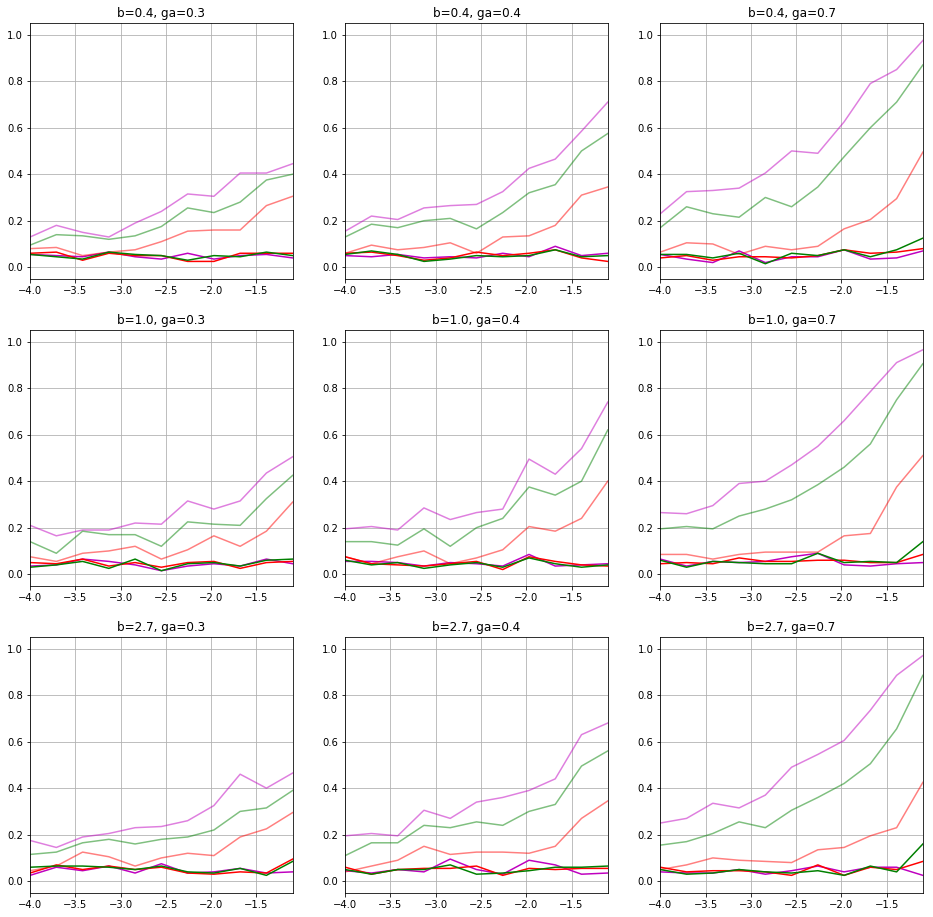

In [515]:
alpha=0.05
plt.figure(figsize=(16,16))
x=gbs
for i in range(bs.size):
    for j in range(gas.size):
        b=bs[i];ga=gas[j]
        plt.subplot(bs.size,gas.size,i*gas.size+j+1)
        plt.title('b=%.1f, ga=%.1f'%(b,np.exp(ga)))
        for ii in range(3):
            sel=~np.all(np.isnan(D[i,j,:,:,ii*3+1]),axis=1)
            plt.plot(x[sel],(D[i,j,:,:,ii*3+2]<alpha).mean(1)[sel],['m','r','g'][ii])
            plt.plot(x[sel],np.mean(D[i,j,:,:,ii*3+1]<alpha,1)[sel],['m','r','g'][ii],alpha=0.5)
        plt.ylim([-0.05,1.05]) 
        plt.xlim([np.min(x),np.max(x)])
        plt.grid()

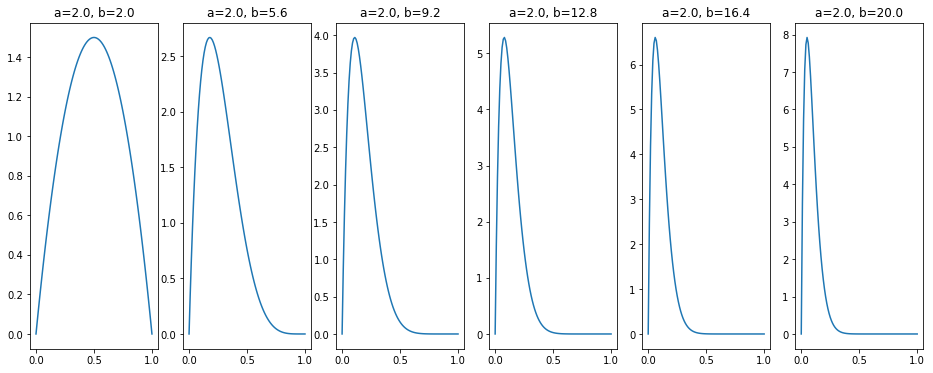

In [539]:
plt.figure(figsize=(16,6))
gbs=np.linspace(2,20,6)
gas=-2
for j in range(gbs.size):
    plt.subplot(1,gbs.size,j+1)
    gas=2
    #a,b=gg2ab(gas,gbs[j])
    a=gas;b=gbs[j]
    x=np.linspace(0,1,101)
    plt.plot(x,stats.beta.pdf(x,a,b))
    plt.title('a=%.1f, b=%.1f'%(a,b))

# a,b parametrization

In [6]:
log(2)

0.69314718055994529

In [560]:
bs=np.exp(np.linspace(-1,1,3))
gas=np.array([0.5,1,2])
gbs=np.linspace(22,2,11)#np.linspace(-4,-0.7,21)
ginc=0.1
N=100
R=200
D=np.zeros((bs.size,gas.size,gbs.size,R,17))
# TOST threshold
ta=int(gas.size/2);tb=int(gbs.size/2)
tmp1=[gas[ta],gbs[tb]]
tmp2=[gas[ta],gbs[tb]*ginc]
delta=-np.array([ginc,tmp1[0]/(tmp1[1]+tmp1[0])-tmp2[0]/(tmp2[1]+tmp2[0])])
for i in range(bs.size):
    print(i)
    for j in range(gas.size):
        for r in range(R):
            for h in range(gbs.size):
                dat=[];
                #if np.exp(gas[j])+np.exp(gbs[h])>1:
                #    D[i,j,h,r,:]=np.nan
                #    continue
                for g in range(2):
                    #a,b=gg2ab(gas[j],gbs[h]+ginc*g)
                    a=gas[j];b=gbs[h]*np.exp(ginc*g)
                    dat.append(stats.beta.rvs(a,b,0,bs[i],size=N))
                    dat[-1][dat[-1]==bs[i]]=bs[i]-np.exp(-20)
                    dat[-1][dat[-1]==0]=np.exp(-20)
                    D[i,j,h,r,[2*g,2*g+1]]=[np.mean(logit(dat[-1]/bs[i])),
                                            np.var(logit(dat[-1]/bs[i]),ddof=1)]
                    D[i,j,h,r,[2*g+4,2*g+5]]=[np.mean(dat[-1]),np.var(dat[-1],ddof=1)]
                ts=[]
                for g in range(2):
                    t,p=stats.ttest_ind_from_stats(D[i,j,h,r,2+g*4],
                            np.sqrt(D[i,j,h,r,3+g*4]),N, D[i,j,h,r,g*4],
                            np.sqrt(D[i,j,h,r,1+g*4]),N, equal_var=False)
                    D[i,j,h,r,8+g]=(t>0)*p/2+(1-p/2)*(t<=0)
                    # bayes factor in favor of no difference
                    t,p=stats.ttest_ind_from_stats(D[i,j,h,r,2+g*4],
                            np.sqrt(D[i,j,h,r,3+g*4]),N, D[i,j,h,r,g*4],
                            np.sqrt(D[i,j,h,r,1+g*4]),N, equal_var=True)
                    nn=N/2;v=2*N-2
                    f=lambda g:(2*np.pi*(1+nn*g))**-0.5*((1+(t**2)/(1+nn*g)/v)**(-(v+1)/2)*g**-1.5*np.exp(-1/2/g))
                    denom=quad(f,0,np.inf)[0]
                    D[i,j,h,r,15+g]=(1+t**2/v)**(-(v+1)/2)/denom
                D[i,j,h,r,10]=stats.mannwhitneyu(dat[0],dat[1],alternative='less')[1]
                #TOST
                for g in range(2):
                    for gg in range(2):
                        t,p=stats.ttest_ind_from_stats(D[i,j,h,r,g*4+2]+[-1,1][gg]*delta[g],
                                                       np.sqrt(D[i,j,h,r,g*4+3]),N,
                            D[i,j,h,r,g*4],np.sqrt(D[i,j,h,r,g*4+1]),N, equal_var=False)
                        D[i,j,h,r,11+gg+g*2]=[(t<=0)*p/2+(1-p/2)*(t>0),(t>0)*p/2+(1-p/2)*(t<=0)][gg]


0
1
2


array([ 22.,  20.,  18.,  16.,  14.,  12.,  10.,   8.,   6.,   4.,   2.])

In [1]:
def plotCI(x,y,sd,df,clr='b',alpha=0.05):
    sel=np.isnan(y)
    if np.any(sel):
        x=x[~sel];y=y[~sel];sd=sd[~sel];df=df[~sel]
    plt.grid(True)
    plt.plot(x,y,clr)
    xx=np.concatenate([x,x[::-1]])
    
    lb=y+sd*stats.t.ppf(alpha/2,df)
    ub=y+sd*stats.t.ppf(1-alpha/2,df)
    ci=np.concatenate([lb,ub[::-1]])
    #print(ci)
    plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
            alpha=0.2,fill=True,fc=clr,ec=clr))

plt.figure(figsize=(16,16))
yl=[1,1,1]
x=gbs
for i in range(bs.size):
    for j in range(gas.size):
        beta=bs[i];a=gas[j]
        plt.subplot(bs.size,gas.size,i*gas.size+j+1)
        plt.title('b=%.1f, ga=%.1f'%(beta,a))
        for ii in range(2):
            d=np.nanmedian(D[i,j,:,:,ii*4]-D[i,j,:,:,2+ii*4],axis=1)
            v2=D[i,j,:,:,3+ii*4];v1=D[i,j,:,:,1+ii*4]
            sd= np.sqrt(np.nanmedian(v1+v2,axis=1))/np.sqrt(2*N)
            df=np.floor(np.square((1+np.nanmedian(v1/v2,1))/N)/
                        ((1+np.square(np.nanmedian(v1/v2,1)))/(N**2*(N-1))))
            plotCI(x,d,sd,df,['m','r'][ii])
        #plotEstim(x,D[i,j,:,:,6]-D[i,j,:,:,4],'r')
        #plt.plot(x,ks*(kinc-1),'b')
        plt.plot(x,ginc*np.ones(x.shape),'c')
        #plt.ylim([-0.5,yl[j]])
        plt.ylim([-.5,1])

NameError: name 'plt' is not defined

# stan analysis

In [5]:
def ordinalLogitERvs(beta, c,n,size=1):
    ''' generate data with expected response
        frequency from n subjects
    '''
    # c must be strictly increasing
    assert np.all(np.diff(c)>0) 
    def invLogit(x): return 1/(1+np.exp(-x))
    p=[1]+list(invLogit(beta-c))+[0]
    p=-np.diff(p)
    #return np.random.multinomial(n,p,size)
    return np.int32(np.round(p*n))
def reformatData(dat):
    out=[]
    for k in range(dat.size):
        out.extend([k]*dat[k])
    return np.array(out)
b=np.linspace(-10,7,11)
d=1
c=np.array([-5,-3,-1,1,3,5])
S=[];P=[]
for bb in b:
    S.append([np.squeeze(ordinalLogitERvs(bb,c,100)),
        np.squeeze(ordinalLogitERvs(bb+d,c,100))])
    P.append([reformatData(S[-1][0]),
             reformatData(S[-1][1])])
for k in range(b.size): 
    i1=np.nonzero(S[k][0]!=0)[0]
    i2=np.nonzero(S[k][1]!=0)[0]
    if max((S[k][0]!=0).sum(),(S[k][1]!=0).sum())<9:
        s= max(min(i1[0],i2[0])-1,0)
        e= min(max(i1[-1],i2[-1])+1,10)
        S[k][0]=S[k][0][s:e+1]
        S[k][1]=S[k][1][s:e+1]

In [3]:
model='''
data {
    int<lower=2> K;
    int<lower=0> y1[K];// response control
    int<lower=0> y2[K];// response treatment
}
parameters {
    real<lower=-1000,upper=1000> d;
    ordered[K-1] c;
}
model {
for (k in 1:(K-1)) c[k]~ uniform(-200,200);
for (k in 1:K){
    for (n in 1:y1[k]) k~ ordered_logistic(0.0,c);
    for (n in 1:y2[k]) k~ ordered_logistic(d  ,c);
}}
'''
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3863612723aa87f9526232c8bb8a40a0 NOW.


In [6]:
ds=[];cs=[]
for k in range(len(S)):
    if S[k][0].size==1: continue
    dat = {'y1':S[k][0],'y2':S[k][1],'K':S[k][0].size}
    fit = sm.sampling(data=dat,iter=2000, 
        chains=4,thin=2,warmup=500,n_jobs=4,seed=4)
    print(fit)
    saveStanFit(fit,'d%d'%k)

Inference for Stan model: anon_model_3863612723aa87f9526232c8bb8a40a0.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d       1.0    0.05   1.46  -1.68   0.03    0.9   1.87   4.03    837    1.0
c[1]   5.18    0.04   1.19   3.35   4.31    5.0   5.86   7.86    746   1.01
c[2]  101.2    2.43  54.43  11.26  54.35  99.59 147.82 194.23    503   1.01
lp__   -6.0    0.06   1.44  -9.59  -6.68  -5.71  -4.93   -4.2    596   1.01

Samples were drawn using NUTS at Tue Apr  9 12:09:24 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Inference for Stan model: anon_model_3863612723aa87f9526232c8bb8a40a0.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d      1.28    0.03   0.72  -0.03   0.79   1.25   1.74   2.82    603    1.0
c[1]   3.65    0.03   0.63   2.56    3.2    3.6   4.05   5.02    554    1.0
c[2]   6.78    0.05    1.3    4.7   5.88   6.63   7.48   9.69    745   1.01
c[3]  99.42    2.34  53.71  12.78  52.26  99.49 143.32  193.3    529    1.0
lp__ -37.16    0.05   1.54 -40.89 -37.95 -36.88 -36.03 -35.08    810    1.0

Samples were drawn using NUTS at Tue Apr  9 12:09:30 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Inference for Stan model: anon_model_3863612723aa87f9526232c8bb8a40a0.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d      0.71    0.46   0.71  -0.67   0.12   0.93   1.23   1.71      2   2.47
c[1]    1.3    0.45   0.68   0.16   0.53   1.54   1.78   2.17      2   3.14
c[2]   3.41    0.52   0.82   2.06   2.49   3.62    4.0   4.62      2   2.37
c[3]   6.34    0.34   1.27   4.84    5.4   6.02   6.95   9.75     14   1.14
c[4]  91.82   17.53  53.66  15.15  46.04  76.89 137.36 193.23      9   1.17
lp__ -130.9    5.72    8.2 -146.1 -140.7 -126.6 -125.4 -124.0      2   5.91

Samples were drawn using NUTS at Tue Apr  9 12:10:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Inference for Stan model: anon_model_3863612723aa87f9526232c8bb8a40a0.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d      1.05  8.5e-3   0.27   0.53   0.86   1.04   1.23   1.59   1023    1.0
c[1]  -0.06  7.9e-3   0.19  -0.44  -0.18  -0.06   0.06   0.31    581    1.0
c[2]   1.94  8.6e-3   0.24   1.48   1.78   1.94    2.1   2.43    807    1.0
c[3]   4.05    0.02   0.44   3.24   3.74   4.02   4.35   4.95    778    1.0
c[4]   6.61    0.04   1.24   4.68   5.74   6.43   7.29   9.56    836    1.0
c[5] 105.94    2.46  54.79  12.15  59.87 106.69 153.81 194.65    497    1.0
lp__ -216.2    0.07   1.82 -220.5 -217.2 -215.9 -214.9 -213.7    764    1.0

Samples were drawn using NUTS at Tue Apr  9 12:10:56 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
conv

Inference for Stan model: anon_model_3863612723aa87f9526232c8bb8a40a0.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d      1.02  6.9e-3   0.27    0.5   0.83   1.01   1.19   1.54   1484    1.0
c[1]  -1.78    0.01   0.25  -2.29  -1.95  -1.78  -1.61  -1.32    432   1.01
c[2]   0.22  5.9e-3   0.19  -0.15   0.09   0.22   0.35   0.61   1080    1.0
c[3]   2.29  9.1e-3   0.26   1.82   2.12   2.28   2.46   2.81    807    1.0
c[4]   4.65    0.03   0.58   3.64   4.26    4.6   5.01   5.92    489    1.0
c[5] 100.25     2.5  54.66   11.8  53.71  99.25 145.65 193.78    477   1.01
lp__ -242.7    0.06   1.79 -247.1 -243.6 -242.4 -241.4 -240.1    766   1.01

Samples were drawn using NUTS at Tue Apr  9 12:11:12 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
conv

Inference for Stan model: anon_model_3863612723aa87f9526232c8bb8a40a0.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d      1.06  5.4e-3   0.27   0.53   0.89   1.07   1.25   1.59   2468    1.0
c[1]  -3.63    0.03   0.54   -4.8  -3.99   -3.6  -3.23  -2.65    389   1.01
c[2]  -1.54  7.9e-3   0.24  -2.03  -1.69  -1.54  -1.37  -1.08    958    1.0
c[3]   0.53  4.6e-3    0.2   0.14    0.4   0.53   0.66   0.95   1910    1.0
c[4]   2.59  7.9e-3   0.28   2.06    2.4   2.58   2.77   3.18   1252    1.0
c[5]   4.72    0.02    0.6   3.66   4.29   4.68   5.09   5.99    642    1.0
c[6] 100.31    2.76  55.43  10.74  52.92  99.39 147.45 195.51    403   1.01
lp__ -253.2    0.08   2.01 -257.9 -254.2 -252.8 -251.7 -250.2    707    1.0

Samples were drawn using NUTS at Tue Apr  9 12:11:28 2019.
For each parameter, n_eff is a crude measure of effective sample size

Process ForkPoolWorker-74:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-76:
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
Traceback (most re

KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-77:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res

In [45]:
ds=[];xs=[]
for k in range(b.size):
    try:
        f=loadStanFit('d%d'%k)['d']
        xs.append(b[k])
        ds.append(f)
    except:pass
ds=np.array(ds);xs=np.array(xs)
res1=errorbar(ds.T,x=xs-0.1)
res2=np.zeros((b.size,5))
for k in range(b.size):
    res2[k,:]=plotCIttest2(y1=P[k][0],
                y2=P[k][1],x=b[k]+0.1)
plt.gca().set_visible(False)



TypeError: errorbar() got multiple values for argument 'x'

In [30]:
plt.figure(figsize=(8,4))
ax1=plt.gca()
plt.plot([-10,5],[0,0],'k')
temp=[list(xs)+list(xs)[::-1],
    list(res1[:,1])+list(res1[:,2])[::-1]]
ax1.add_patch(plt.Polygon(xy=np.array(temp).T,
    alpha=0.2,fc='k',ec='k'))
plt.plot(xs,res1[:,0],'k',alpha=0.4)
plt.ylim([-1.5,2])
plt.grid(b=False,axis='x')
plt.legend(['True ES','Estimate Ordinal Logit'],loc=8)
plt.ylabel('deltaT - deltaC')
plt.xlabel('deltaC')
plt.grid(b=False,axis='both')
ax2 = ax1.twinx()
temp=[list(b)+list(b)[::-1],
    list(res2[:,1])+list(res2[:,2])[::-1]]
for t in range(len(temp[0]))[::-1]:
    if np.isnan(temp[1][t]):
        temp[0].pop(t);temp[1].pop(t)
ax2.add_patch(plt.Polygon(
    xy=np.array(temp).T,alpha=0.2,fc='m',ec='m'))
plt.plot(b,res2[:,0],'m')
plt.ylim([-1.5/d1*d2,2/d1*d2])
plt.xlim([-9,4.5])
plt.plot(-np.median(w['beta'],axis=0),[-0.3]*6,'+b',mew=2)
plt.plot(-np.median(w['beta']-np.atleast_2d(w['dd'][:,1]).T,
                    axis=0),[-0.5]*6,'+g',mew=2)
plt.legend(['Estimate T - C',
    'Item Neg-Difficulty Original Study',
    'Item Neg-Difficulty Replication'],loc=4)
plt.ylabel('T - C',color='m')
plt.grid(b=False,axis='both')
for tl in ax2.get_yticklabels():tl.set_color('m')

In [58]:
cld=1
cls=np.linspace(-5,5,21)
c=np.array([-3,-1,1,3])
D=[]
for i in range(cls.size):
    s0=orderedLogitRvs(cls[i],c,100)[0,:]
    s1=orderedLogitRvs(cls[i]+cld,c,100)[0,:]
    D.append([s0,s1])

In [23]:
model='''
data {
    int<lower=2> K;
    int<lower=0> y1[K];// response control
    int<lower=0> y2[K];// response treatment
}
parameters {
    real<lower=-1000,upper=1000> d;
    ordered[K-1] c;
}
model {
for (k in 1:(K-1)) c[k]~ uniform(-200,200);
for (k in 1:K){
    for (n in 1:y1[k]) k~ ordered_logistic(0.0,c);
    for (n in 1:y2[k]) k~ ordered_logistic(d  ,c);
}}
'''
smOLRM=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3863612723aa87f9526232c8bb8a40a0 NOW.


In [30]:
dat = {'y1':s0,'y2':s1,'K':c.size+1}
fit = smOLRM.sampling(data=dat,iter=2000, chains=4,thin=2,warmup=500,n_jobs=4,seed=4)
print(fit)

Inference for Stan model: anon_model_3863612723aa87f9526232c8bb8a40a0.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d      1.43  7.2e-3   0.38   0.67   1.17   1.42   1.67   2.23   2877    1.0
c[1]   2.12  6.1e-3   0.32   1.52    1.9    2.1   2.32   2.78   2789    1.0
c[2]   4.35  9.4e-3    0.5   3.41   4.01   4.34   4.67   5.38   2811    1.0
c[3]   6.96    0.02   1.33   4.96   6.02   6.74   7.67  10.03   2823    1.0
c[4]   7.93    0.03   1.63   5.44   6.77   7.67   8.84  11.89   2745    1.0
lp__ -117.0    0.04   1.63 -121.1 -117.8 -116.7 -115.8 -114.8   1945    1.0

Samples were drawn using NUTS at Wed Mar 27 13:44:16 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [48]:
model='''
data {
    int<lower=2> N;
    real y1[N];// response control
    real y2[N];// response treatment
}
parameters {
    real<lower=-5,upper=5> d;
    real<lower=0,upper=5> s[2];
    real<lower=-5,upper=5> m;
}
model {
    y1~normal(m,s[1]);
    y2~normal(m+d,s[2]);
}
'''
smNorm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bca70794c9bbffd2f1b5a9590dd30156 NOW.


In [60]:
res=[]
for j in range(cls.size):
    dat = {'N':100}
    for i in range(2):
        p=(2*reformat(D[j,i,:])+1)/2./float(c.size+1)
        dat['y'+str(i+1)]=logit(p)
    fit = smNorm.sampling(data=dat,iter=2000, chains=4,thin=2,warmup=500,n_jobs=4,seed=4)
    print(fit)
    res.append(sap(fit.extract()['d'],[5,50,95]))
res=np.array(res)

Inference for Stan model: anon_model_bca70794c9bbffd2f1b5a9590dd30156.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d       0.3  1.8e-3    0.1   0.11   0.24    0.3   0.36   0.49   2767    1.0
s[1]   0.62  8.3e-4   0.04   0.54   0.59   0.62   0.65   0.72   2927    1.0
s[2]   0.75  1.1e-3   0.05   0.65   0.71   0.75   0.78   0.86   2408    1.0
m     -2.01  1.2e-3   0.06  -2.13  -2.05  -2.01  -1.97  -1.89   2756    1.0
lp__ -21.41    0.03   1.42 -24.97 -22.11  -21.1 -20.38 -19.63   2252    1.0

Samples were drawn using NUTS at Wed Mar 27 14:58:14 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_bca70794c9bbffd2f1b5a9590dd30156.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup

Inference for Stan model: anon_model_bca70794c9bbffd2f1b5a9590dd30156.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d       0.5  2.4e-3   0.12   0.26   0.42   0.51   0.58   0.74   2594    1.0
s[1]    0.9  1.3e-3   0.07   0.78   0.85   0.89   0.94   1.04   2683    1.0
s[2]   0.79  1.1e-3   0.06   0.68   0.75   0.78   0.82   0.91   2827    1.0
m     -0.05  1.7e-3   0.09  -0.23  -0.11  -0.05 6.2e-3   0.12   2622    1.0
lp__ -62.44    0.03   1.42 -66.01 -63.17 -62.15 -61.37 -60.66   2200    1.0

Samples were drawn using NUTS at Wed Mar 27 14:58:17 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_bca70794c9bbffd2f1b5a9590dd30156.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup

Inference for Stan model: anon_model_bca70794c9bbffd2f1b5a9590dd30156.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d   -5.1e-4  1.3e-3   0.07  -0.13  -0.05-1.7e-3   0.05   0.13   2533    1.0
s[1]   0.48  7.0e-4   0.04   0.41   0.45   0.47    0.5   0.55   2598    1.0
s[2]   0.48  6.5e-4   0.03   0.42   0.45   0.47    0.5   0.55   2865    1.0
m      2.05  9.3e-4   0.05   1.96   2.01   2.04   2.08   2.14   2582    1.0
lp__  49.66    0.03   1.39  46.01   49.0  49.96  50.69  51.43   2007    1.0

Samples were drawn using NUTS at Wed Mar 27 14:58:20 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


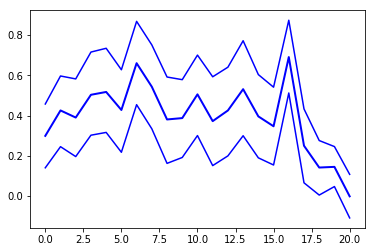

In [67]:
plt.plot(res[:,0],'b')
plt.plot(res[:,1],'b',lw=2)
plt.plot(res[:,2],'b')

# Beta model

In [75]:
model='''
data {
    int<lower=2> N;
    real<lower=0,upper=1> y1[N];// response control
    real<lower=0,upper=1> y2[N];// response treatment
}
parameters {
    real<lower=0,upper=30> a[2];
    real<lower=0,upper=30> b[2];
}
model {
    y1~beta(a[1],b[1]);
    y2~beta(a[2],b[2]);
}
'''
smBeta=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_637ef4abfd7df2b4797cf558100026dd NOW.


In [77]:
res=[]
for j in range(cls.size):
    dat = {'N':100}
    for i in range(2):
        temp=reformat(D[j,i,:])/float(c.size)
        temp[temp==0]=1e-4
        temp[temp==1]=1-1e-4
        dat['y'+str(i+1)]= temp
    fit = smBeta.sampling(data=dat,iter=2000, chains=4,thin=2,warmup=500,n_jobs=4,seed=4)
    print(fit)
    res.append(sap(fit.extract()['d'],[5,50,95]))
res=np.array(res)

Inference for Stan model: anon_model_637ef4abfd7df2b4797cf558100026dd.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]    0.1    0.04   0.06  3e-14   0.04   0.12   0.13   0.15      2   5.26
a[2]   0.13    0.05   0.08  3e-14   0.05   0.16   0.18   0.21      2   5.11
b[1]    1.1    0.46    0.7  3e-14   0.28    1.3   1.58   2.14      2   2.56
b[2]   1.43    0.55   0.84   0.02   0.71   1.68   2.01   2.64      2   2.61
lp__ -546.9  1768.1 2501.3  -4880  -2282 896.71 897.79 898.74      2 2031.4

Samples were drawn using NUTS at Fri Mar 29 16:01:58 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


KeyError: 'd'

# Beta-Binomial

In [79]:
model='''
data {
    int<lower=2> N;
    int<lower=2> K;
    int<lower=0,upper=K> y1[N];// response control
    int<lower=0,upper=K> y2[N];// response treatment
}
parameters {
    real<lower=0,upper=30> a[2];
    real<lower=0,upper=30> b[2];
}
model {
    y1~beta_binomial(K,a[1],b[1]);
    y2~beta_binomial(K,a[2],b[2]);
}
'''
smBetaBinom=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f091e445c2506112492a2c0bc22999db NOW.


In [81]:
res=[]
for j in range(cls.size):
    dat = {'N':100,'K':c.size}
    for i in range(2):
        dat['y'+str(i+1)]= reformat(D[j,i,:])
    fit = smBetaBinom.sampling(data=dat,iter=2000, chains=4,thin=2,warmup=500,n_jobs=4,seed=4)
    print(fit)
    w=fit.extract()
    res.append([w['a'],w['b']])
res=np.array(res)

Inference for Stan model: anon_model_f091e445c2506112492a2c0bc22999db.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]   0.49  7.0e-3   0.32   0.09   0.24   0.41   0.68   1.27   2138    1.0
a[2]   2.33    0.02   0.75   0.92    1.8   2.32   2.84   3.81   1899    1.0
b[1]  13.01    0.17   7.68   2.25   6.42  11.64  18.56  28.47   2000    1.0
b[2]  21.41    0.14   5.92    8.8  17.26  22.15  26.37  29.65   1744    1.0
lp__ -182.9    0.04   1.47 -186.5 -183.6 -182.5 -181.7 -181.0   1614    1.0

Samples were drawn using NUTS at Fri Mar 29 16:15:21 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_f091e445c2506112492a2c0bc22999db.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup

Inference for Stan model: anon_model_f091e445c2506112492a2c0bc22999db.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]  21.84    0.13   4.98   10.8  18.67  22.54  25.72  29.43   1395    1.0
a[2]  24.29    0.12   4.51  13.79  21.46  25.36  28.04  29.84   1341    1.0
b[1]  22.82    0.14   5.08   11.2  19.57   23.8  26.92  29.63   1356    1.0
b[2]  15.17    0.09   3.25    8.5  13.03  15.38  17.47  21.03   1358    1.0
lp__ -540.2    0.05   1.82 -544.8 -541.1 -539.8 -538.9 -537.9   1124    1.0

Samples were drawn using NUTS at Fri Mar 29 16:17:50 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_f091e445c2506112492a2c0bc22999db.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup

Inference for Stan model: anon_model_f091e445c2506112492a2c0bc22999db.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]  19.15    0.15   7.02   5.16  13.94  20.02  25.06  29.45   2136    1.0
a[2]   19.3    0.16   7.07   5.34  14.03   20.1  25.39  29.55   1899    1.0
b[1]   0.63  6.3e-3   0.31   0.16    0.4    0.6   0.82   1.32   2348    1.0
b[2]   0.64  6.4e-3    0.3   0.16   0.41    0.6   0.82    1.3   2245    1.0
lp__ -104.7    0.04   1.53 -108.6 -105.5 -104.4 -103.6 -102.8   1776    1.0

Samples were drawn using NUTS at Fri Mar 29 16:19:54 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


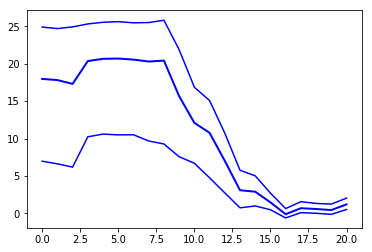

In [84]:
temp=[]
for j in range(cls.size):
    t=sap(np.log(res[j,0,:,0])-np.log(res[j,1,:,0])-np.log(res[j,0,:,1])+res[j,1,:,1],[5,50,95])
    temp.append(t)
temp=np.array(temp)
plt.plot(temp[:,0],'b')
plt.plot(temp[:,1],'b',lw=2)
plt.plot(temp[:,2],'b')

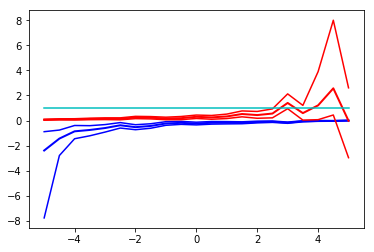

In [95]:
temp0=[];temp1=[]
for j in range(cls.size):
    c0=ab2gg(res[j,0,:,0],res[j,1,:,0])
    c1=ab2gg(res[j,0,:,1],res[j,1,:,1])
    temp0.append(sap(c0[0]-c1[0],[5,50,95]))
    temp1.append(sap(c0[1]-c1[1],[5,50,95]))
temp0=np.array(temp0)
temp1=np.array(temp1)
plt.plot(cls,temp0[:,0],'b')
plt.plot(cls,temp0[:,1],'b',lw=2)
plt.plot(cls,temp0[:,2],'b')
plt.plot(cls,temp1[:,0],'r')
plt.plot(cls,temp1[:,1],'r',lw=2)
plt.plot(cls,temp1[:,2],'r')
plt.plot(cls,np.ones(cls.shape),'c')

In [32]:
def invlogit(x): return 1/(1+np.exp(-x))
def orderedLogitRvs(beta, c,n,size=1):
    ''' generate data with expected response
        frequency from n subjects
    '''
    # c must be strictly increasing
    c=np.array(c)
    assert np.all(np.diff(c)>0) 
    
    p=[1]+list(invlogit(beta-c))+[0]
    p=-np.diff(p)
    if size<1: 
        proposal=np.int32(p*n)
        restsort=np.argsort((p*n)-proposal)[::-1]
        #print(p*n,proposal,restsort)
        for i in range(n-proposal.sum()):
            proposal[restsort[i]]+=1
        assert(proposal.sum()==n)
        out=[]
        for g in range(proposal.size):
                out.extend([g]*int(proposal[g])) 
        return np.array(out)
    else: 
        dat=np.random.multinomial(n,p,size)
        v=range(dat.shape[1])
        out=[]
        for r in range(dat.shape[0]):
            out.append([])
            for g in range(dat.shape[1]):
                out[-1].extend([v[g]]*int(dat[r,g])) 
        return np.array(out)
  






# Schnall study

In [2]:
def rescaleW(w):
    offset=np.array(w['c'][:,0]/2+w['c'][:,-1]/2,ndmin=2).T
    scale=np.array(np.abs(w['c'][:,0]-w['c'][:,-1])/2,ndmin=2).T
    w['c']=(w['c']-offset)/scale
    try:
        for i in range(2):
            w['tbeta'][:,i,:]=(w['tbeta'][:,i,:]+offset)/scale
            w['beta'][:,i,:]=(w['beta'][:,i,:]+offset)/scale
    except KeyError: pass
    w['d']=w['d']/scale
    return w


array([-7.72086762, -7.47049304, -7.22011846, -6.96974388, -6.7193693 ,
       -6.46899472, -6.21862014, -5.96824556, -5.71787098, -5.4674964 ,
       -5.21712182, -4.96674724, -4.71637266, -4.46599808, -4.2156235 ,
       -3.96524892, -3.71487434, -3.46449976, -3.21412518, -2.9637506 ,
       -2.71337602, -2.46300144, -2.21262686, -1.96225228, -1.7118777 ,
       -1.46150312, -1.21112854, -0.96075396, -0.71037938, -0.4600048 ,
       -0.20963022,  0.04074436,  0.29111894,  0.54149352,  0.7918681 ,
        1.04224268,  1.29261726,  1.54299184,  1.79336642,  2.043741  ,
        2.29411558,  2.54449016,  2.79486474,  3.04523932,  3.2956139 ,
        3.54598848,  3.79636306,  4.04673764,  4.29711222,  4.5474868 ,
        4.79786138])

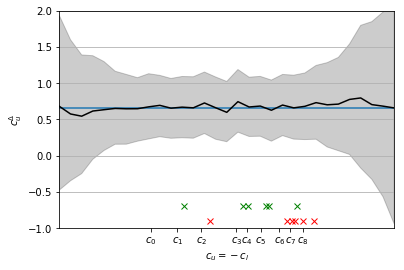

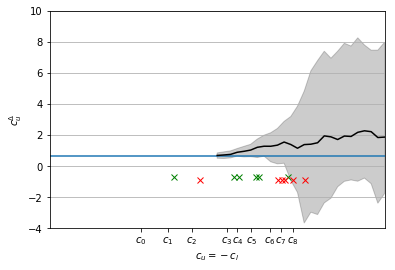

# Wald variance investigation 

In [102]:
def Wpdf(x,np1,np2,b,a=1):
    scl=np.square(a/np2)
    #mm=np2**1.5/a**0.5/b
    mm=a/b/scl
    return stats.invgauss.pdf(x,mm,loc=0,scale=scl)   
def Wrvs(b,bd,s,n,a=1):
    scl=np.square(a/s)
    mm=a/(b+bd)/scl
    res=stats.invgauss.rvs(mm,loc=0,scale=scl,size=n)
    res[res==0]=np.exp(-20)
    return np.log(res),res

def Wrvs2(b,bd,s,n,a=1):
    res=np.random.wald(a/(b+bd),a/np.square(s),size=n)
    res[res==0]=np.exp(-20)
    return np.log(res),res
def Wpdf2(x,np1,np2,b,a=1):
    ss=np2
    return a/ss/np.sqrt(2*np.pi*np.power(x,3))*np.exp(-b**2/ss**2/2/x*np.square(x-a/b))
def Wvar(np1,np2,b,a=1):
    scl=np.square(a/np2)
    mm=a/b/scl
    return stats.invgauss.var(mm,loc=0,scale=scl) 
def Wvar2(np1,np2,b,a=1):
    return a*np.square(np2)*np.power(b,-3)
        

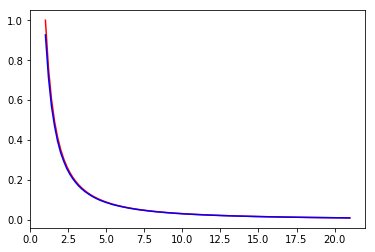

In [125]:
x=np.linspace(0,1,201)
sig=1
b=np.linspace(1,21,101)
y=np.sqrt(Wvar(0,sig,b))
plt.plot(b,y,'r')
y=[]
for bb in b.tolist():
    D=Wrvs(bb,0,sig,500000)[1]
    D=np.reshape(D,[50,10000])
    
    y.append(np.median(np.std(D,ddof=1,axis=0)))
plt.plot(b,y,'b')
#plt.ylim([0,10])

In [117]:
D

(array([-0.95273368,  0.42646361, -1.90233527, ..., -0.30760885,
         1.10893005, -0.01313489]),
 array([0.38568524, 1.53183079, 0.14921974, ..., 0.73520284, 3.03111352,
        0.98695099]))

(0, 10)

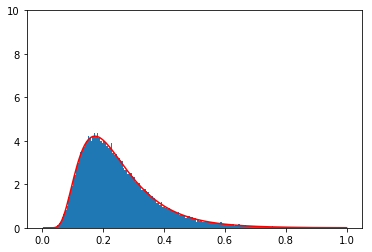

In [64]:
x=np.linspace(0,1,201)
m=0.25;s=1
y=np.sqrt(s/2/np.pi*np.power(x,-3))*np.exp(-s*np.square(x-m)/x/2/np.square(m))
b=1/m;a=1;ss=np.sqrt(1/s)
y=a/ss/np.sqrt(2*np.pi*np.power(x,3))*np.exp(-b**2/ss**2/2/x*np.square(x-a/b))
plt.plot(x,y,'r')
dd=np.random.wald(m,s,size=50000)
plt.hist(dd,bins=x,normed=True)
plt.ylim([0,10])

In [32]:
s

1